In [3]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)
# import warnings
import seaborn as sns
import scipy
from scipy import stats
# warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import talib as ta
import scipy
from scipy import stats
import mplfinance as mpf
# from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 50)  # Display up to 50 columns
pd.set_option('display.max_colwidth',100)  # Display up to 100 characters per column value

# !pip install plotly
import plotly

In [ ]:
def regenerate_interval(csv, interval,  daytype, path,  start='04:20', end='16:30'):
    '''Regenerate interval to get rid of missing rows, NaN, Inf,etc- to get uniform df's  '''
    df = pd.read_csv(csv, parse_dates=True, index_col= 0)
    name = str(csv[-22:]).replace('.csv', '')
    typ = daytype.split(' ')
    yy = [5 if v is 'Up' else -5 if v is 'Down' else 0 if v is 'Range' else -2 if v is 'RangeDown' 
          else 2 if v is 'RangeUp' else 'unknown' for v in typ]
    
    df_resampled = df.resample(interval).pad().fillna(0).replace(0, df.shift(1).max())
    # # Add any missing intervals until the end of the day
    minuT = int(interval[0]) * 60
    end_of_day = pd.date_range(df.index[-1], periods=(pd.Timestamp(df.index[-1]).replace(hour=23, minute=59, second=59) - pd.Timestamp(df.index[-1])).seconds//minuT + 1, freq=interval)[1:]
    df_resampled = df_resampled.reindex(df_resampled.index.union(end_of_day))
    df_resampled = df_resampled.fillna(0)
    df_resampled = df_resampled.between_time(start, end)
   
    folder_path =  path
    df_resampled['day'] = str(daytype)
    df_resampled['type'] = yy[0]
#     print('yy type is: ' , type(yy[0]),'\n-----\n', yy[0])
   
    file_path = os.path.join(folder_path, name + str('_' + daytype) + '.pickle')
    # print('file_path is ',file_path)
    df_resampled.to_pickle(file_path)
    print('Name is: ', name)
    print('Shape is: ', df_resampled.shape)
    # df = pd.read_pickle(name +'.pickle')
    return df_resampled

In [ ]:
# path = r"C:\Repo\DownAfterProblem"
# import glob 
# all_files1 = glob.glob(path + "/*.csv")
# for i in range(len(all_files1)):
#     regenerate_interval(all_files1[i], '2T',  'Down', path, start='04:20', end='16:30')
    

In [7]:
directory_path =  r"C:\Repo\D_47"
dfs = []
for file in os.listdir(directory_path):
    if file.endswith('.pickle'):
        df = pd.read_pickle(os.path.join(directory_path, file))
        dfs.append(df)
down_df = pd.concat(dfs, axis= 0)
# down_df.shape   #   (16836, 8)

# ES Down
- features engineering

In [ ]:
esDown = down_df[down_df['close'] < 6000]

# Calculate OnBalanceVolume indicator and OnBalanceBidAsk indicator
OBV = []
OBV.append(0)
for i in range(1, len(esDown.close)):
    if esDown.close[i] > esDown.close[i-1]: # If the closing price is above the prior close price 
          OBV.append(OBV[-1] + esDown.Vol[i]) # then: Current OBV = Previous OBV + Current Volume
    elif esDown.close[i] < esDown.close[i-1]:
          OBV.append( OBV[-1] - esDown.Vol[i])
    else:
          OBV.append(OBV[-1])
          
obBA = []
obBA.append(0)
for i in range(1, len(esDown.close)):
    if esDown.close[i] > esDown.close[i-1]: # If the closing price is above the prior close price 
          obBA.append(obBA[-1] + esDown.BidAsk[i]) # then: Current OBV = Previous OBV + Current Volume
    elif esDown.close[i] < esDown.close[i-1]:
          obBA.append( obBA[-1] - esDown.BidAsk[i])
    else:
          obBA.append(obBA[-1])

esDown['vari'] = esDown.close - esDown.open
esDown['volat'] = esDown.high - esDown.low
esDown['taly'] = esDown.Vol - esDown.BidAsk

esDown['diff'] = (esDown.close.diff()).fillna(method='bfill') 
esDown['pct_chng'] = esDown.close.pct_change().fillna(method='bfill') * 100  
esDown['fut_10'] = (esDown.close.shift(-10) - esDown.close).fillna(method='ffill')
esDown['fut_5'] = (esDown.close.shift(-5) - esDown.close).fillna(method='ffill')
esDown["volatility"] = (esDown["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
esDown['BA_2m'] = (esDown['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
esDown['BA_5m'] = (esDown['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
esDown['BA_10m'] = (esDown['BidAsk'].rolling(10).mean()).fillna(method='bfill')  

esDown['BA_cs'] = esDown.BidAsk.cumsum()
esDown['BAr_V'] = (esDown.BidAsk.rolling(3).sum() - esDown.Vol).fillna(method='bfill')


esDown['vwap'] = (esDown.Vol * (esDown.high + esDown.low) / 2).cumsum() / esDown.Vol.cumsum() 
esDown['vwapBA'] = ((esDown.Vol * (esDown.high + esDown.low) / 2).cumsum() / esDown.Vol.cumsum() ) / esDown['taly']
esDown['typeD'] = -0.5

esDown['OBV'] = OBV
esDown['obBA'] = obBA

esDown = esDown.replace([np.inf, -np.inf], np.finfo(np.float64).max)
mask = esDown.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 0 
esDown.replace([np.inf, -np.inf], np.nan, inplace=True)
esDown = esDown.replace([np.inf, -np.inf], np.finfo(np.float64).min)

print(esDown.shape)   # (9150, 25)    (8784, 26)
esDown.head()
# esDown.tail()
# esDown.head()
# esDown.sample()
esdays = esDown.groupby(esDown.index.to_period('D')).ngroups # 21
print('ES days are ', esdays)  #  ES days are  21


In [13]:
esDown.describe()

,Vol,BidAsk,open,high,low,close,type,vari,volat,taly,diff,pct_chng,fut_10,fut_5,volatility,BA_2m,BA_5m,BA_10m,BA_cs,BAr_V,vwap,vwapBA,typeD,OBV,obBA
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.0,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8.784000e+03,8784.0,8.784000e+03,8.784000e+03
mean,4311.108379,-14.132969,3953.366405,3954.991974,3951.638234,3953.247382,-5.0,-0.119023,3.353740,4325.241348,-0.017361,-0.000293,-0.184796,-0.086749,5.263225,-14.131717,-14.125501,-14.124670,-54602.847222,-4353.479622,3967.822080,inf,-0.5,-1.270157e+06,9.553573e+05
std,5547.788420,457.246219,134.567142,134.395197,134.759082,134.611311,0.0,2.772729,2.905594,5590.734774,6.537553,0.172178,20.459639,14.488731,16.377751,334.358262,217.829724,155.703336,36119.042381,5697.850523,49.230921,inf,0.0,8.524819e+05,6.082653e+05
min,1.000000,-6858.000000,3594.000000,3597.750000,3591.250000,3594.250000,-5.0,-42.000000,0.000000,-2550.000000,-197.000000,-5.033536,-200.500000,-198.750000,0.000000,-4963.500000,-2521.800000,-1322.300000,-127309.000000,-103971.000000,3905.060290,-9.546892e+01,-0.5,-2.535683e+06,-1.130000e+02
25%,598.000000,-129.000000,3873.750000,3876.000000,3872.000000,3873.500000,-5.0,-1.250000,1.750000,584.000000,-1.250000,-0.031477,-5.000000,-3.250000,1.327367,-110.000000,-83.000000,-67.400000,-72130.000000,-6261.500000,3924.847069,6.243052e-01,-0.5,-2.174087e+06,4.140860e+05
50%,2745.000000,-1.000000,3994.250000,3995.625000,3992.750000,3994.250000,-5.0,0.000000,2.750000,2740.000000,0.000000,0.000000,-0.750000,-0.250000,3.062377,-0.500000,0.600000,0.800000,-54825.000000,-2701.500000,3958.359941,1.411022e+00,-0.5,-1.236380e+06,9.384850e+05
75%,6223.250000,109.000000,4045.562500,4047.312500,4044.250000,4045.750000,-5.0,1.000000,4.250000,6269.500000,1.000000,0.025434,2.750000,2.000000,5.995587,90.000000,65.000000,48.100000,-37024.750000,-553.000000,4012.999421,6.588884e+00,-0.5,-6.205925e+05,1.553135e+06
max,101565.000000,2899.000000,4170.000000,4180.000000,4168.750000,4170.000000,-5.0,60.000000,92.500000,101682.000000,318.250000,8.845806,318.750000,318.750000,625.944391,2046.500000,1234.000000,876.900000,8857.000000,2657.000000,4112.089976,1.797693e+308,-0.5,6.499500e+04,1.892923e+06


In [14]:
#  Total number of infinite values: 0
esDown.sort_index(inplace=True)
# esDown.head()
# esDown.tail(30)
# check for infinite values
mask = esDown.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') # 0
esDown.head()
# esDown = esDown.dropna(axis=0, how='any', subset=['chng'])

# Identify columns with NaN values and count them
nan_columns = esDown.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
print("Number of NaN values per column:", nan_count)
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

Total number of infinite values: 0
Number of NaN values per column: 0

Total number of NaN values in the DataFrame: 0


## Normalize the df

In [15]:
idx_date = esDown.index
print(len(idx_date) )  #  8784
# esDown.index = pd.to_datetime(esDown.index) # make sure its Datetime index

# Group by day
daily_group = esDown.groupby(esDown.index.date)

# # Define the mean normalization scaling function
def mean_normalization(group):
    mean_value = group.mean()
    min_value = group.min()
    max_value = group.max()
    return (group - mean_value) / (max_value - min_value)

# Apply the mean normalization scaling function to each day's 'Close' values
es_centered = daily_group.transform(mean_normalization)

# Display the resulting centered Series
# print(es_centered)
print('index is ', type(es_centered.index))
es_centered = es_centered.sort_index()
# es_centered['typeD'] = -.5


8784
index is  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [16]:
nan_columns = es_centered.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)


Total number of NaN values in the DataFrame: 0


In [45]:
# Deal w Inf values
mask = es_centered.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') #    732
es_centered = es_centered.replace([np.inf, -np.inf], np.finfo(np.float64).max)
print(f'Total number of infinite values: {inf_count}') #    0


Total number of infinite values: 0
Total number of infinite values: 0


In [46]:
unique_dates = np.unique(es_centered.index.date)
print(len(unique_dates))  # 21
unique_dates

21


array([datetime.date(2022, 9, 27), datetime.date(2022, 10, 7),
       datetime.date(2022, 10, 14), datetime.date(2022, 11, 1),
       datetime.date(2022, 11, 9), datetime.date(2022, 11, 15),
       datetime.date(2022, 11, 28), datetime.date(2022, 12, 1),
       datetime.date(2022, 12, 5), datetime.date(2022, 12, 6),
       datetime.date(2022, 12, 13), datetime.date(2022, 12, 15),
       datetime.date(2022, 12, 19), datetime.date(2022, 12, 28),
       datetime.date(2023, 1, 18), datetime.date(2023, 1, 30),
       datetime.date(2023, 2, 8), datetime.date(2023, 2, 9),
       datetime.date(2023, 2, 21), datetime.date(2023, 3, 7),
       datetime.date(2023, 3, 9)], dtype=object)

## Explore features

In [36]:
# del es_centered['typeD']
# del es_centered['type']
es_centered.columns
# es_centered.shape   #   (8784, 23)

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

In [38]:


# Save DataFrame to a pickle file
pickle_file = "ES_D.pkl"
es_centered.to_pickle(pickle_file)

# pickES = "ES_D.pkl"
# loaded_df = pd.read_pickle(pickES)
# loaded_df.head()
# (type(loaded_df.index))

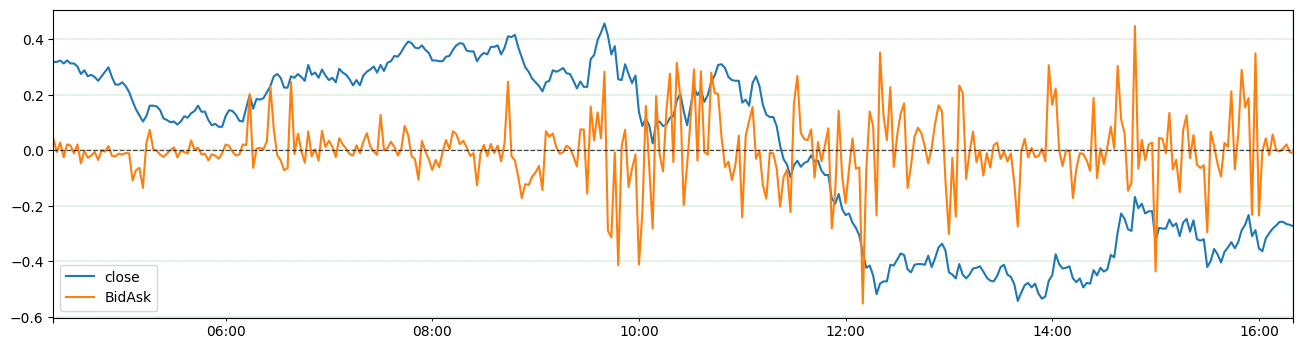

In [20]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close', 'BidAsk'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

In [21]:
es_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'type', 'vari',
       'volat', 'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility',
       'BA_2m', 'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'typeD',
       'OBV', 'obBA'],
      dtype='object')

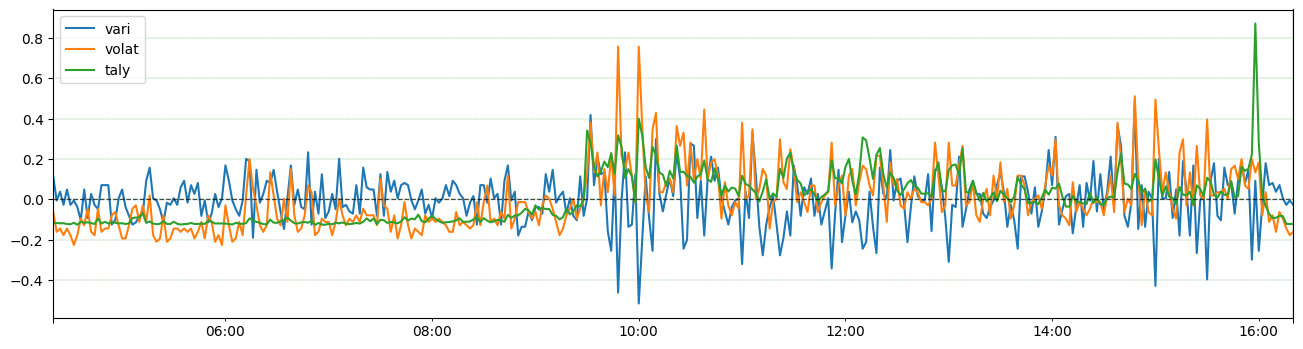

In [22]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['vari', 'volat', 'taly'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

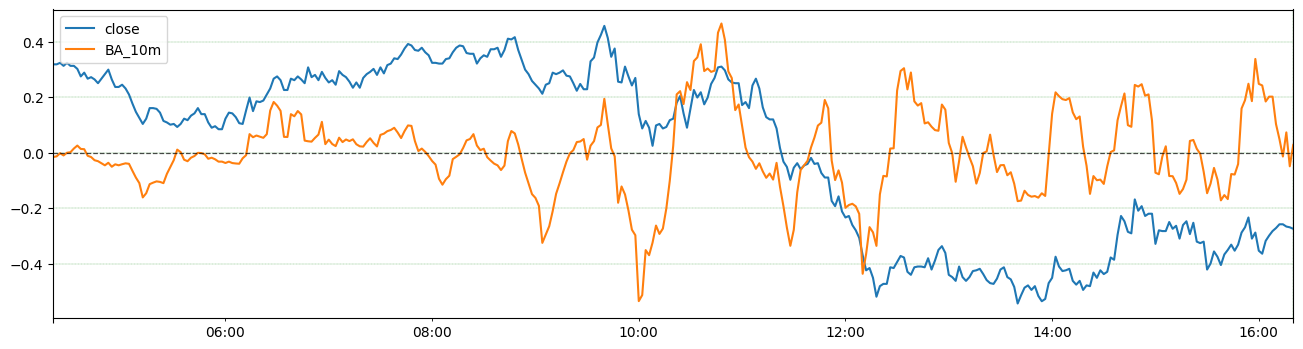

In [23]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close','BA_10m'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

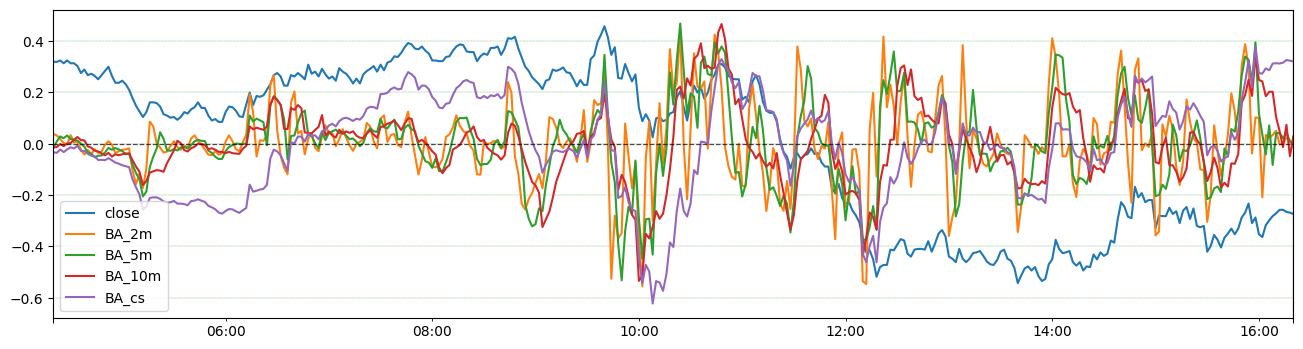

In [24]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close','BA_2m','BA_5m','BA_10m', 'BA_cs'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

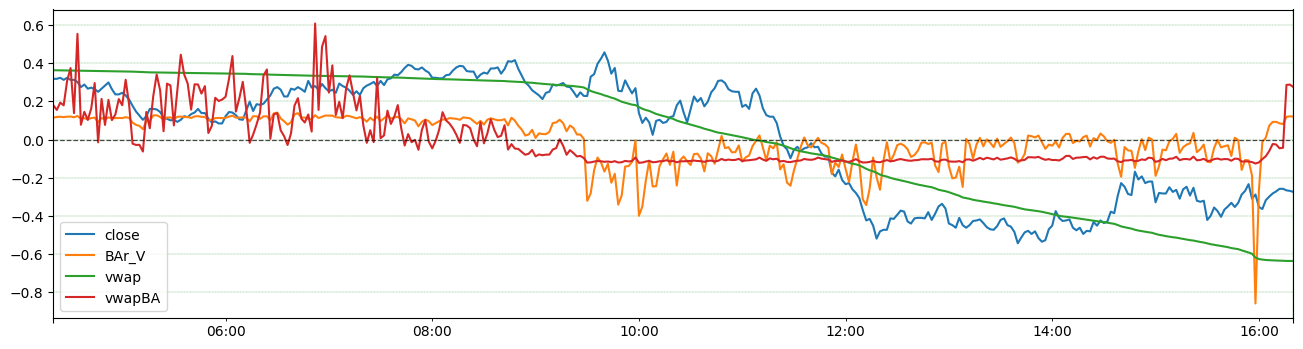

In [25]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close','BAr_V','vwap', 'vwapBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

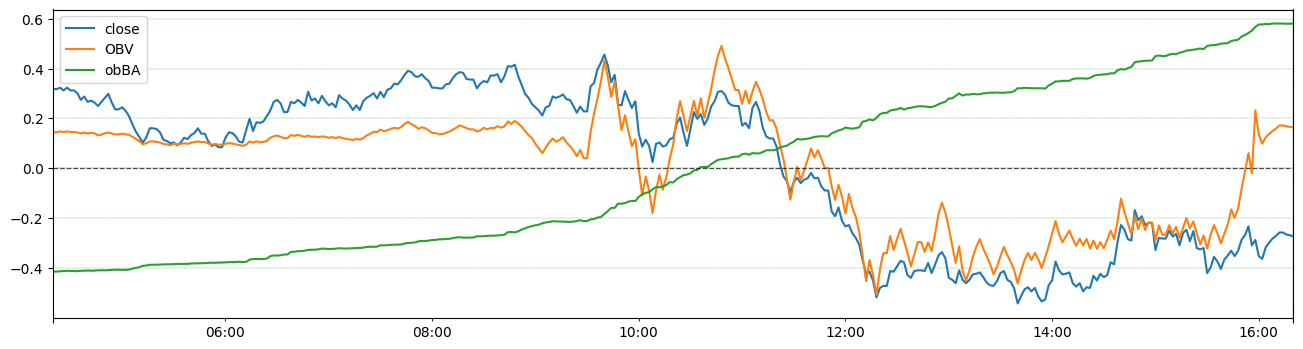

In [26]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close','OBV', 'obBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

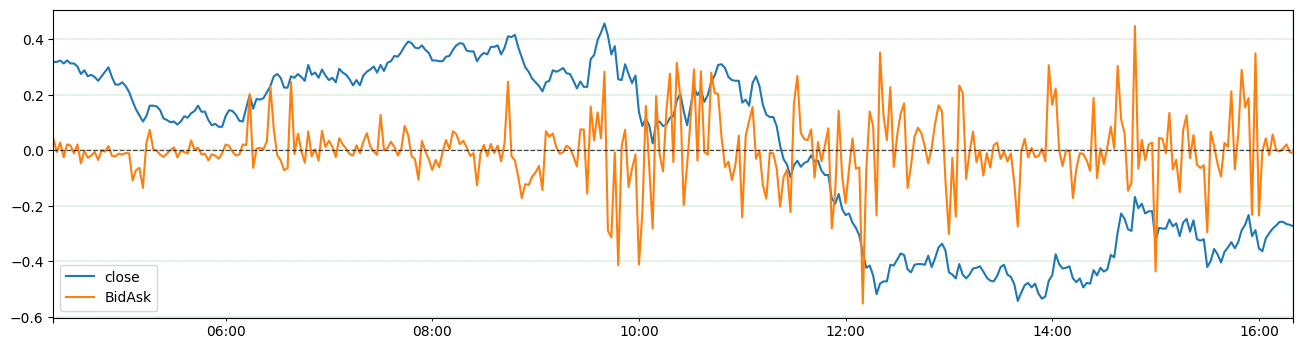

In [27]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close', 'BidAsk'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

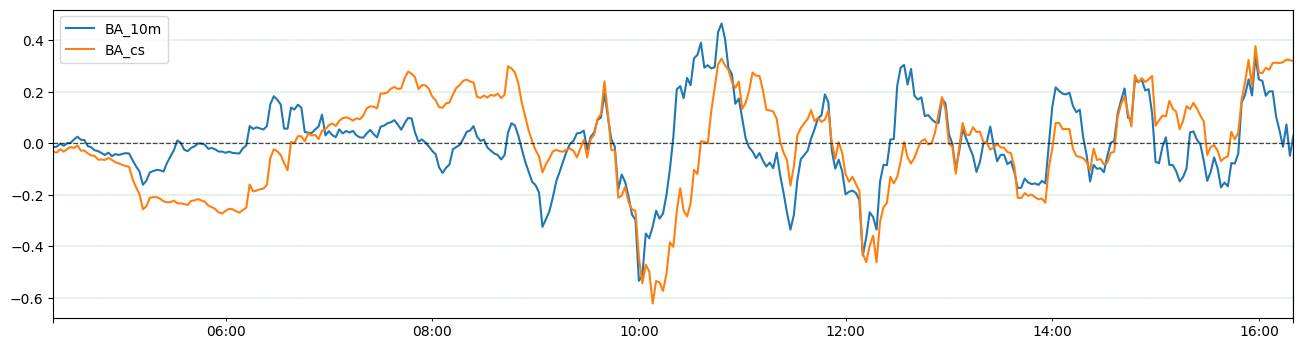

In [28]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['BA_10m', 'BA_cs'], figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

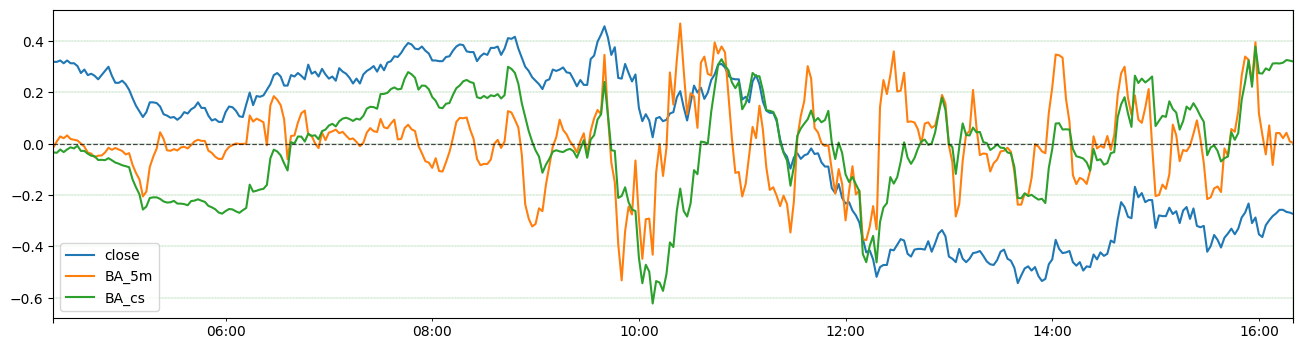

In [29]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['close','BA_5m', 'BA_cs'], figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

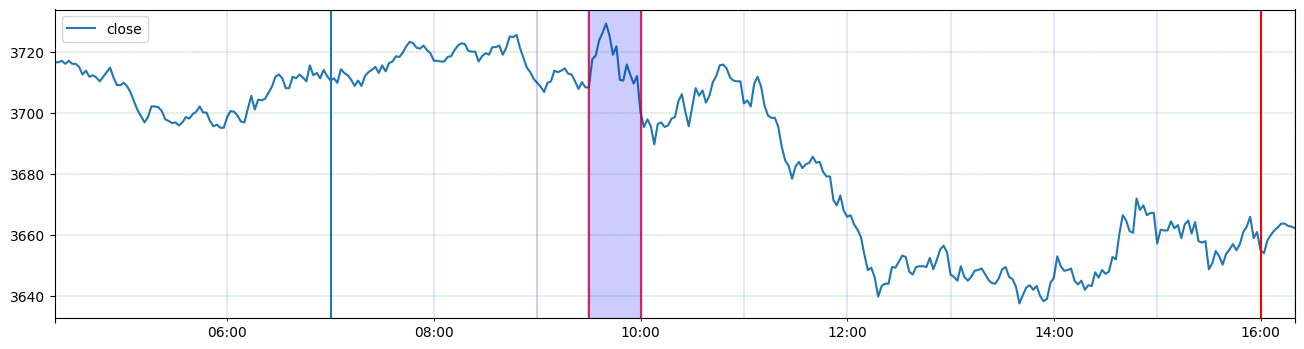

In [30]:
esDown['2022-9-27 04:20:00':'2022-9-27 16:20:00'][['close']].plot( figsize=(16,4))
# plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.axvline(x=  '2022-9-27' + ' 07:00:00')
plt.axvline(x=  '2022-9-27' + ' 06:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 08:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 09:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.2)
plt.axvline(x=  '2022-9-27' + ' 09:30:00', ymax = 1, linewidth= 1.5, color='red', alpha=0.8)
plt.axvline(x=  '2022-9-27' + ' 10:00:00', ymax = 1, linewidth= 1.5, color='red', alpha=0.8)
plt.axvline(x=  '2022-9-27' + ' 09:45:00', ymax = 1, linewidth= 40, color='blue', alpha=0.2)
plt.axvline(x=  '2022-9-27' + ' 11:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 12:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 13:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 14:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 15:00:00', ymax = 1, linewidth= 1.5, color='b', alpha=0.1)
plt.axvline(x=  '2022-9-27' + ' 16:00:00', color= 'red')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

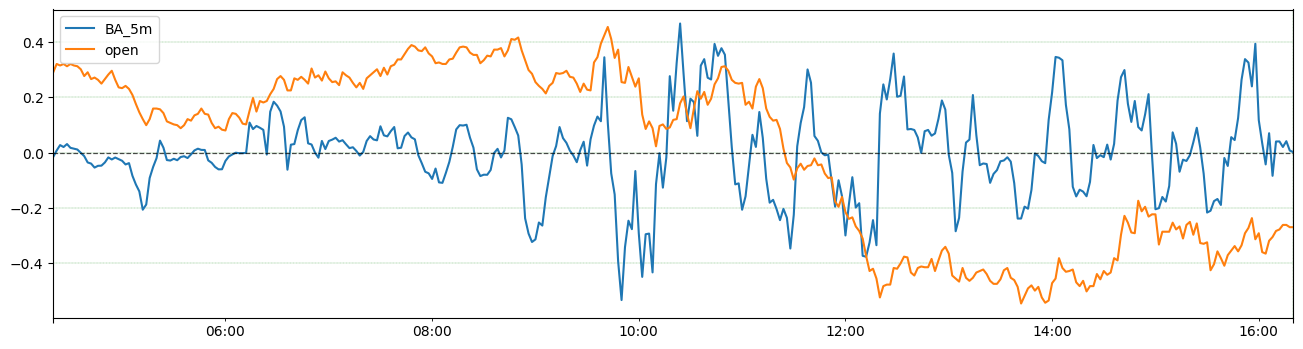

In [31]:
es_centered['2022-9-27 04:20:00':'2022-9-27 16:20:00'].plot(y=['BA_5m', 'open'], figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

In [32]:
unique_dates

array([datetime.date(2022, 9, 27), datetime.date(2022, 10, 7),
       datetime.date(2022, 10, 14), datetime.date(2022, 11, 1),
       datetime.date(2022, 11, 9), datetime.date(2022, 11, 15),
       datetime.date(2022, 11, 28), datetime.date(2022, 12, 1),
       datetime.date(2022, 12, 5), datetime.date(2022, 12, 6),
       datetime.date(2022, 12, 13), datetime.date(2022, 12, 15),
       datetime.date(2022, 12, 19), datetime.date(2022, 12, 28),
       datetime.date(2023, 1, 18), datetime.date(2023, 1, 30),
       datetime.date(2023, 2, 8), datetime.date(2023, 2, 9),
       datetime.date(2023, 2, 21), datetime.date(2023, 3, 7),
       datetime.date(2023, 3, 9)], dtype=object)

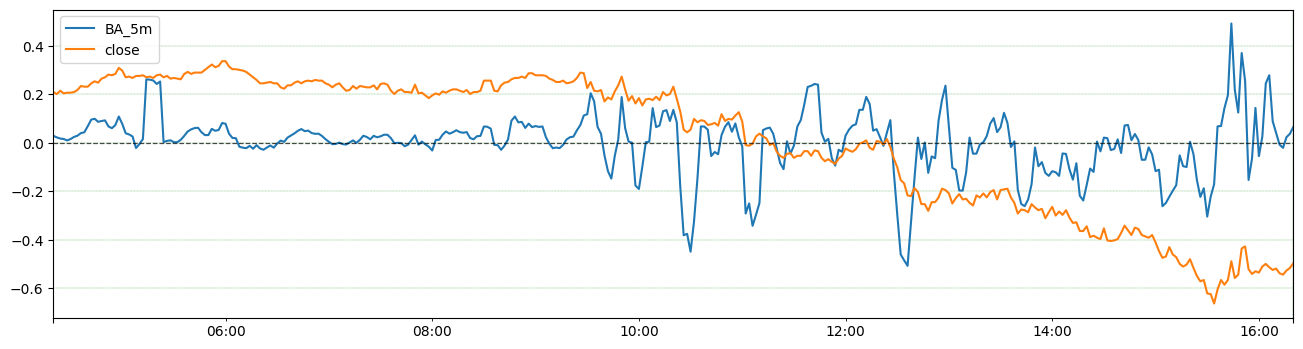

In [33]:
# es_centered['2022-12-06 04:20:00':'2022-12-06  16:00:00'].plot(y=['BA_5m', 'close'], figsize=(16,4))
es_centered['2023, 2, 9 04:20:00':'2023, 2, 9 16:20:00'].plot(y=['BA_5m', 'close'], figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

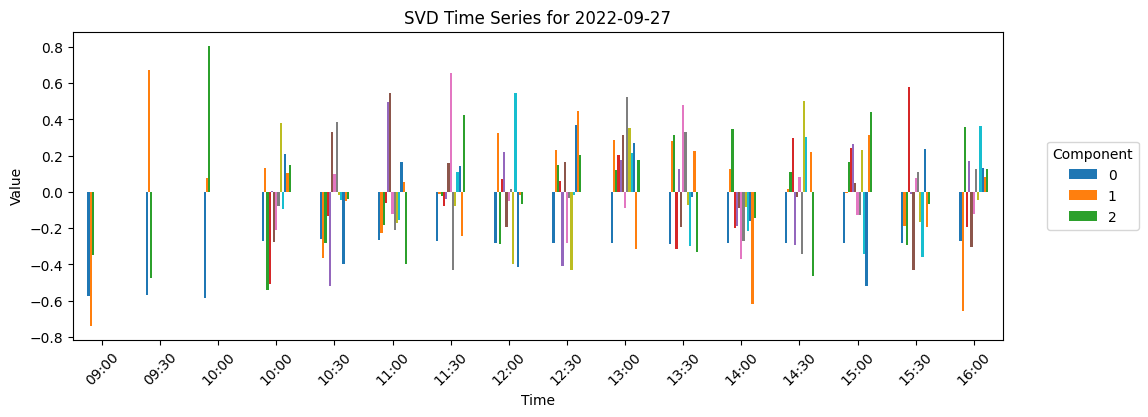

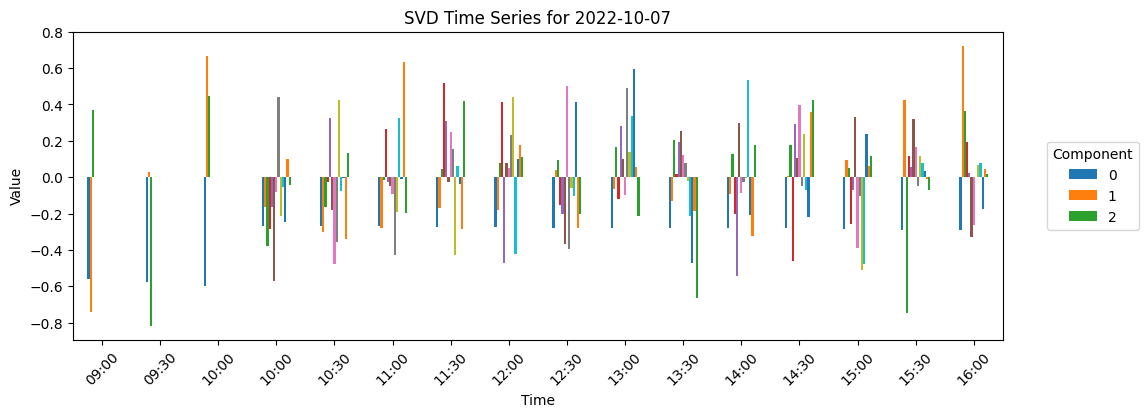

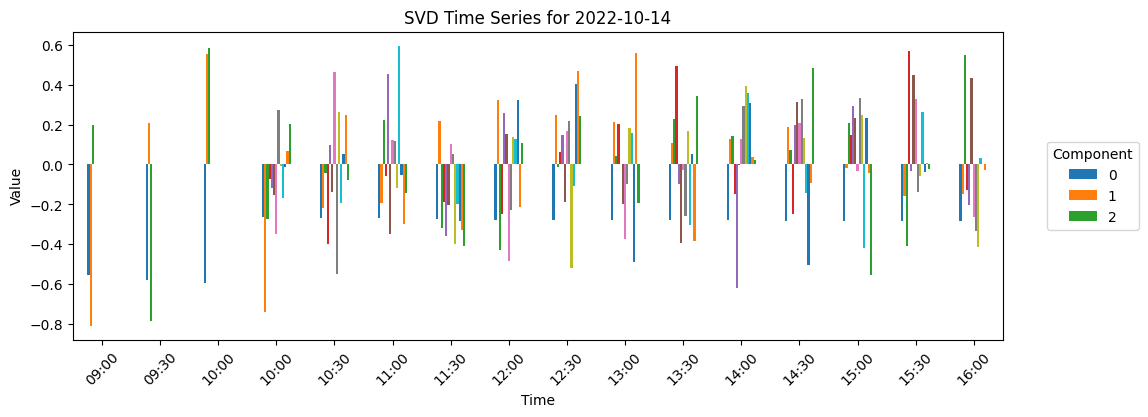

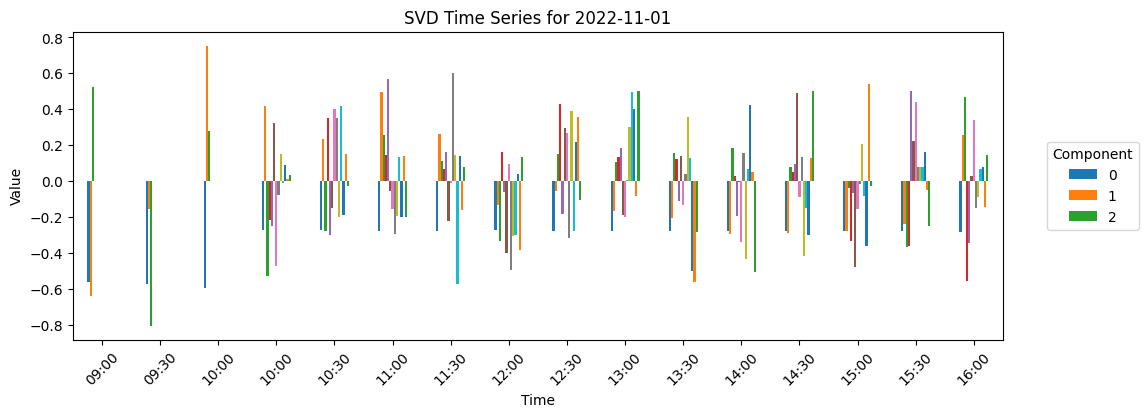

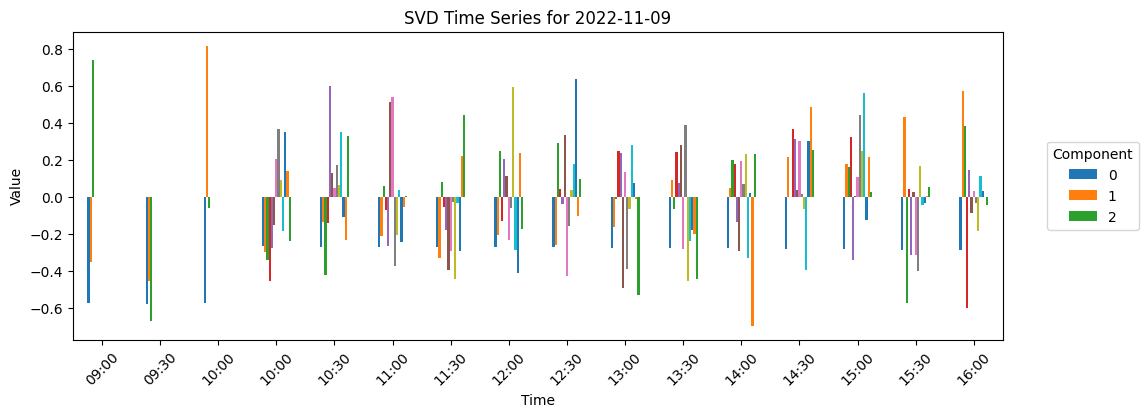

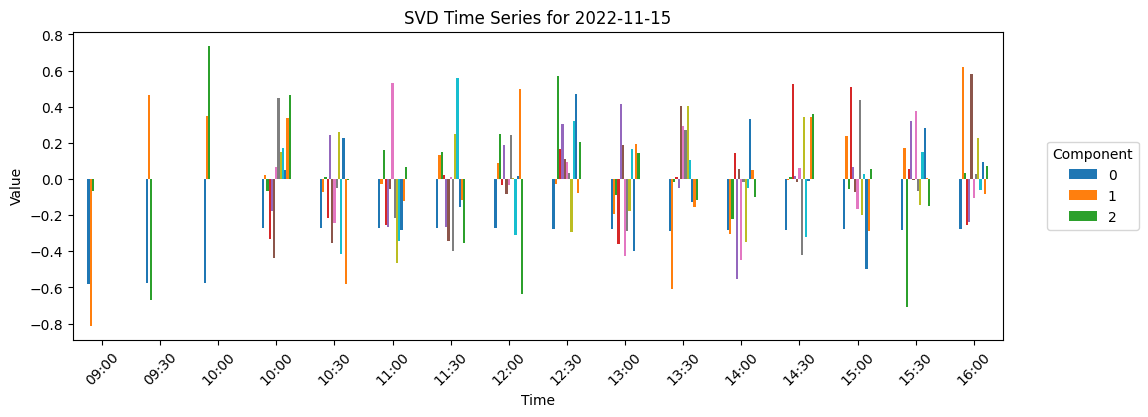

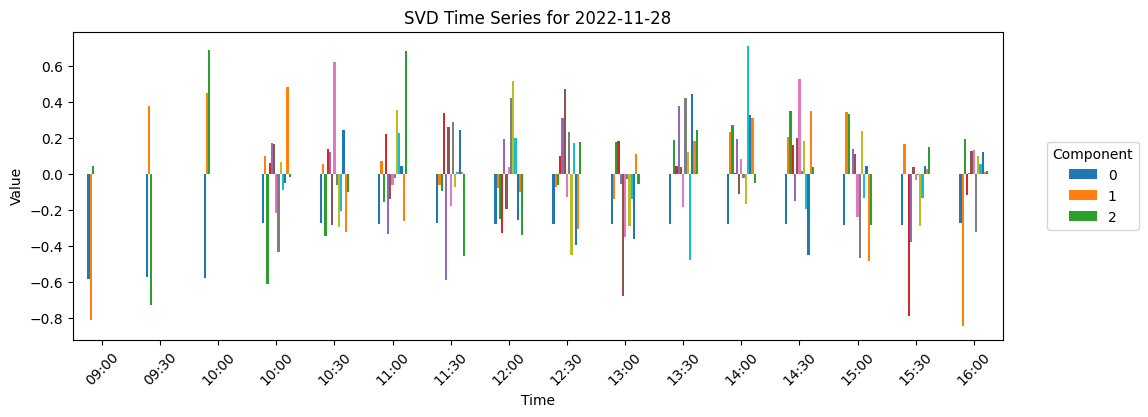

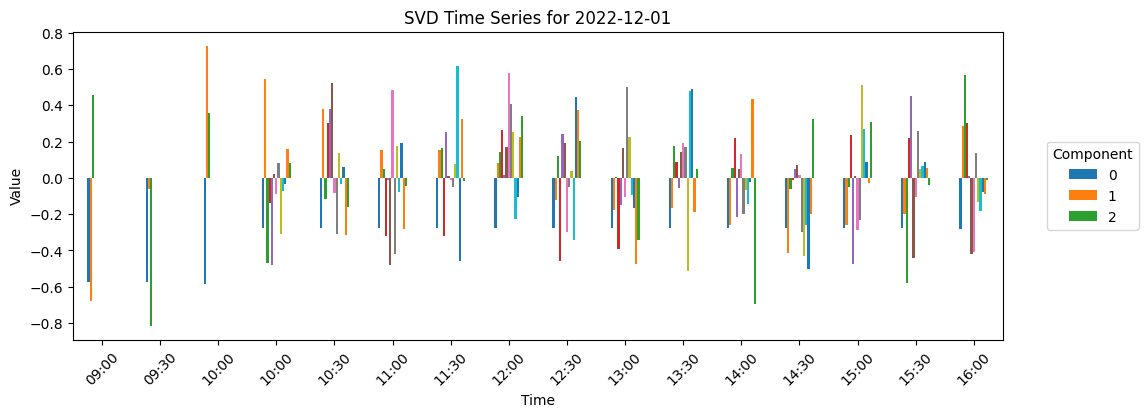

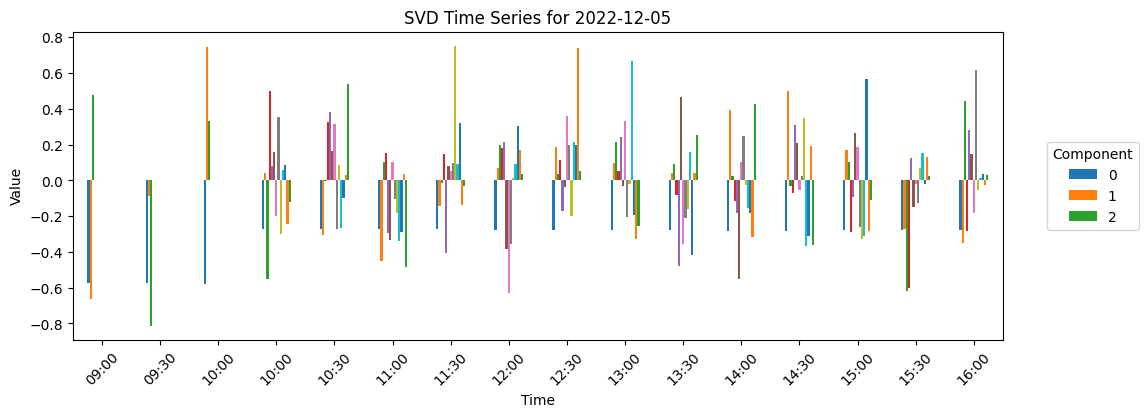

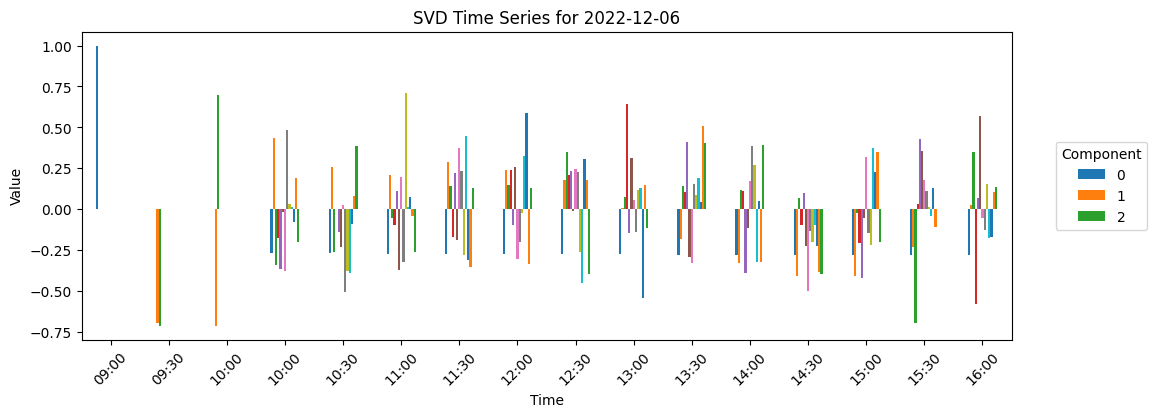

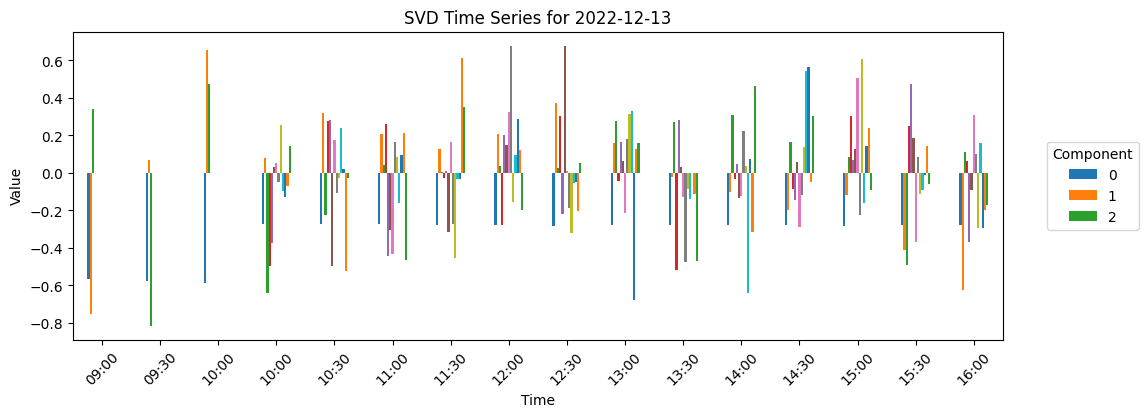

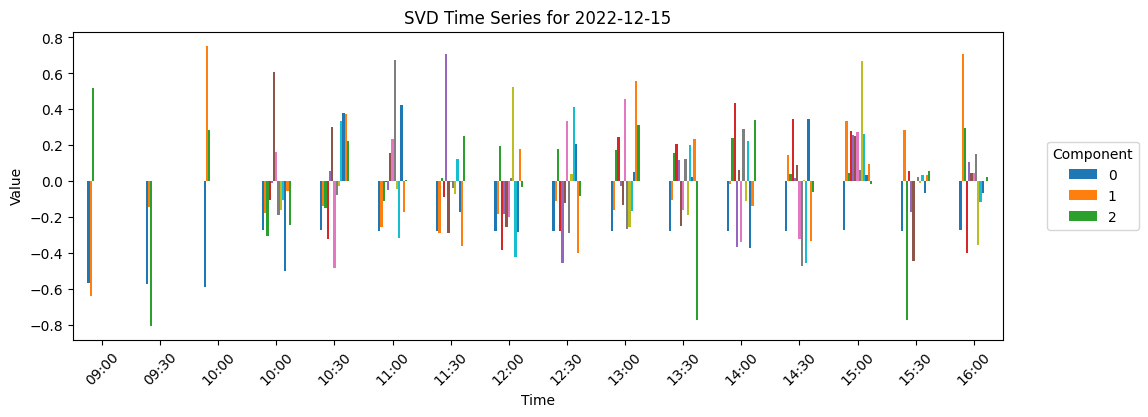

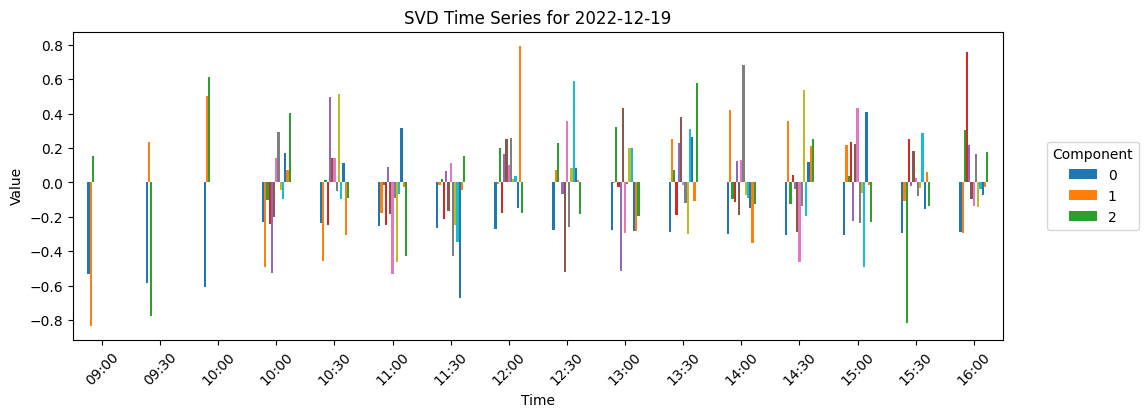

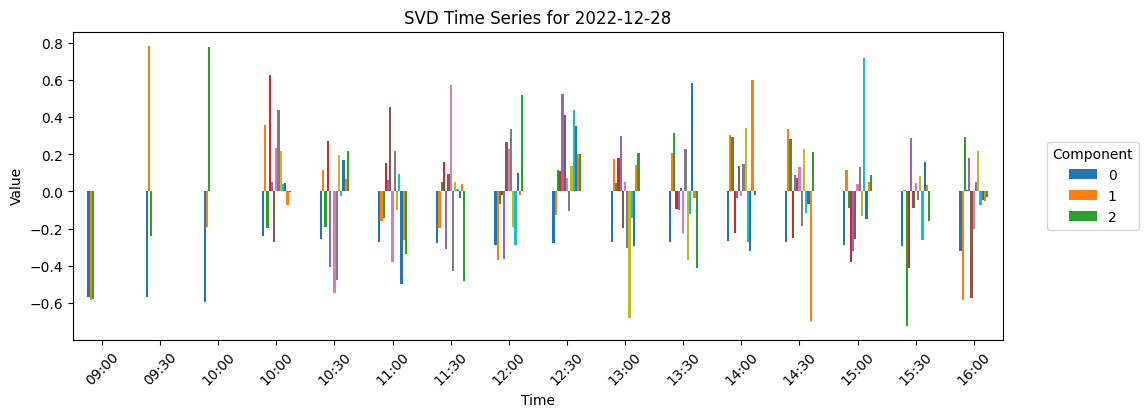

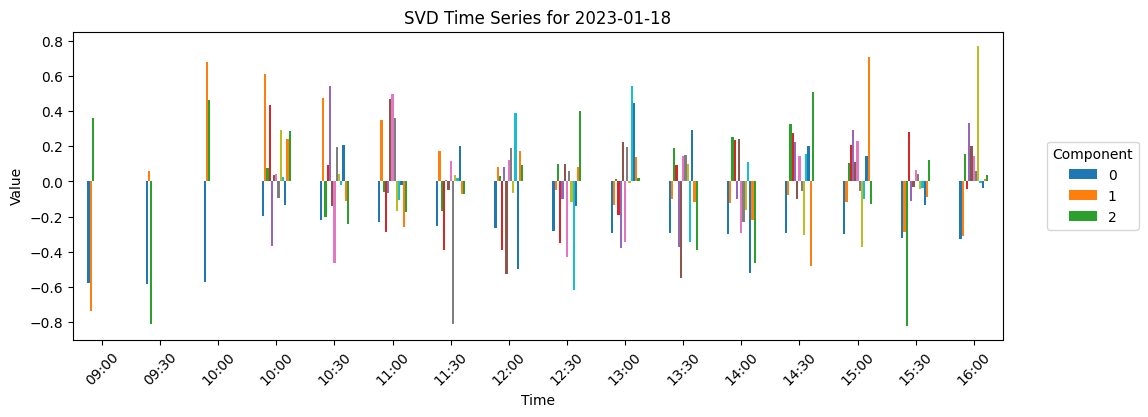

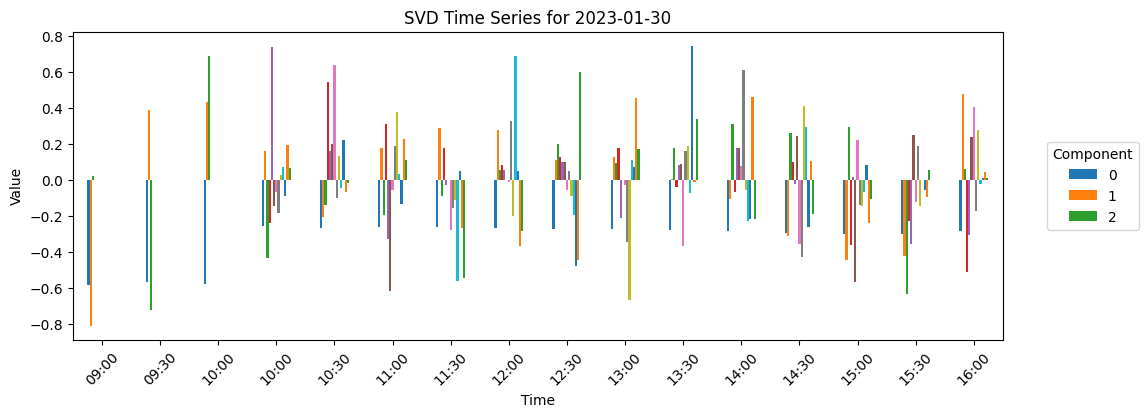

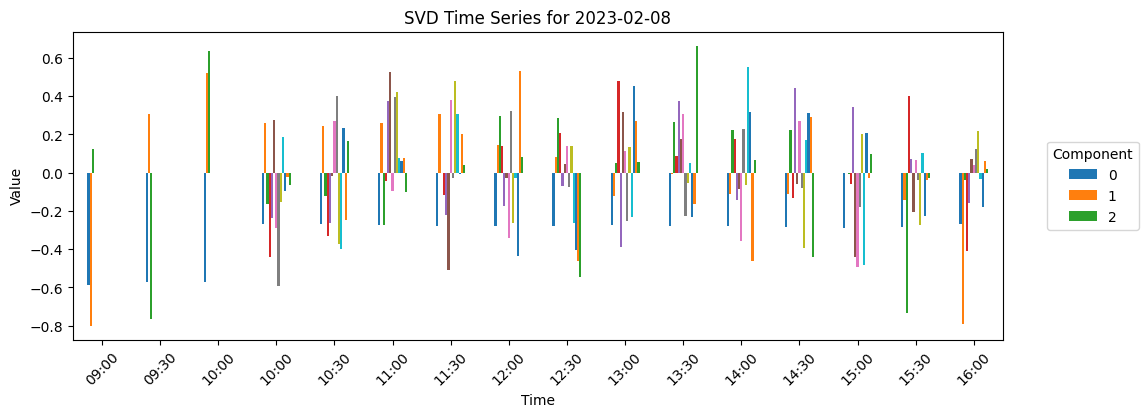

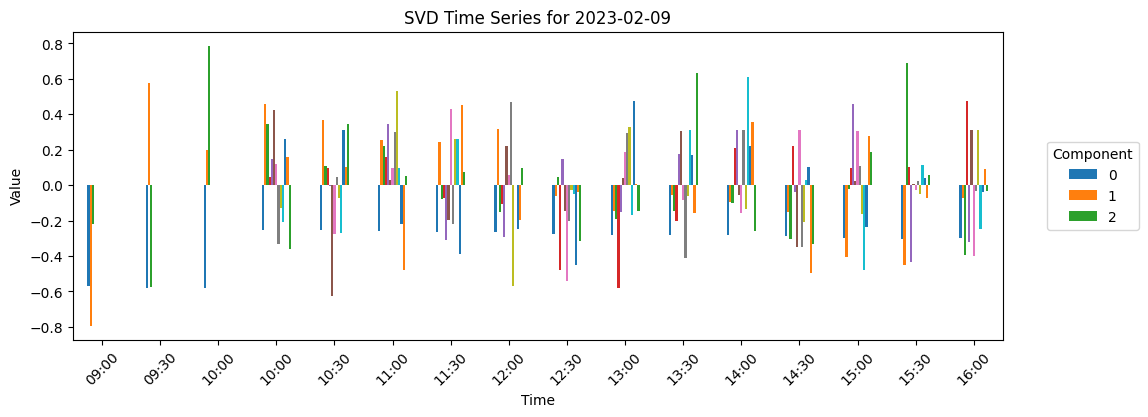

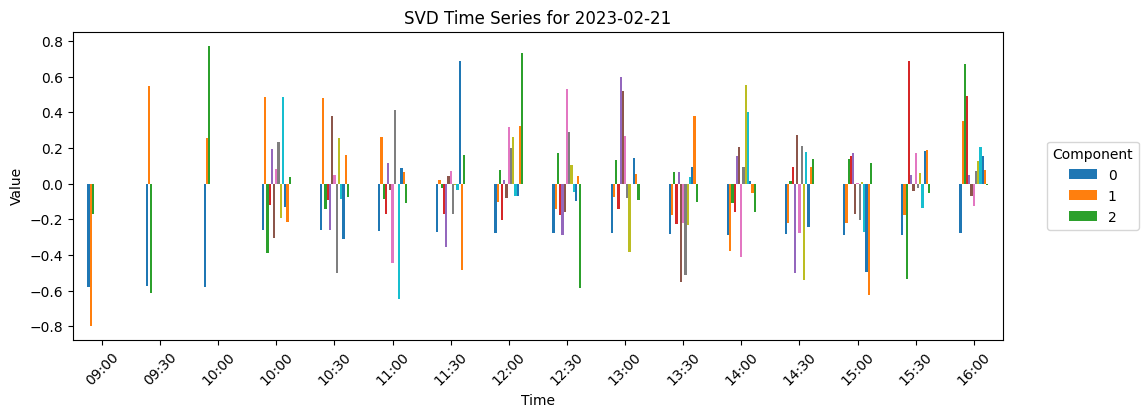

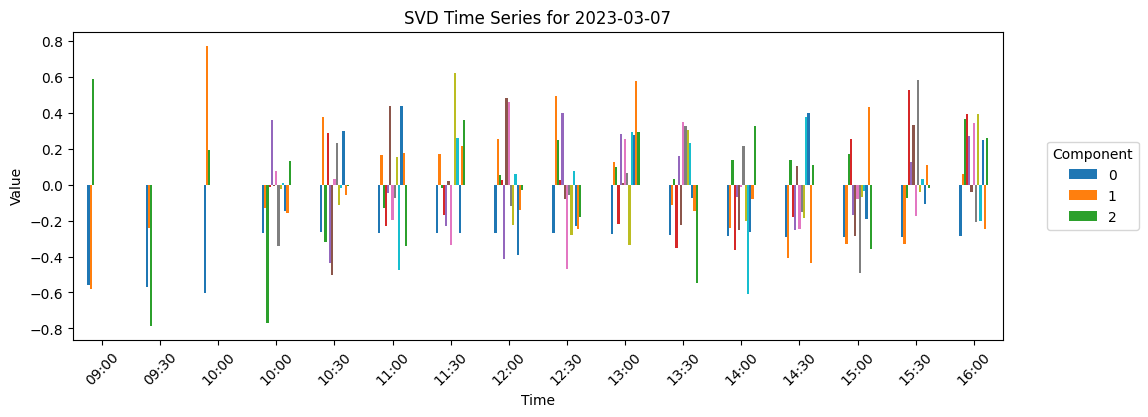

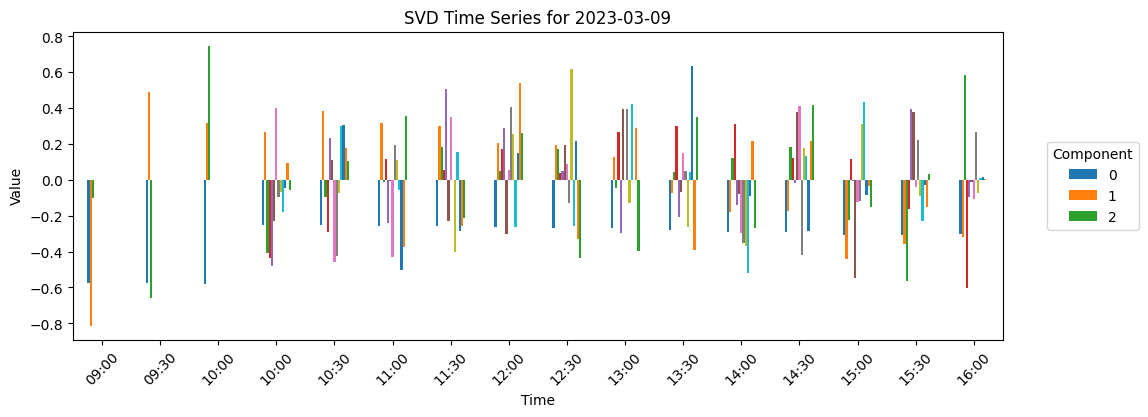

In [524]:
# from scipy.linalg import svd

def clean_data(df):
    # Replace infs with NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaNs or fill them with appropriate values
    df = df.dropna()  # Or  df = df.fillna(some_value)
    return df

# Modify the perform_svd function to clean the data before performing SVD
# def perform_svd(window_data):
#     cleaned_data = clean_data(window_data)
#     U, s, Vt = svd(cleaned_data)
#     return pd.DataFrame(U, index= cleaned_data.index)


# Function to perform SVD on a given data window
def perform_svd(window_data):
    cleaned_data = clean_data(window_data)
    if cleaned_data.shape[0] < 2 or cleaned_data.shape[1] < 2:
        return None
    U, s, Vt = svd(cleaned_data)
    return pd.DataFrame(U, index=cleaned_data.index)

# DataFrame 
# esDown

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = esDown.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)


# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 10 am, and 10 am and 4 pm
    hour_9_to_10 = group.between_time('09:00', '10:00')
    rest_of_hours = group.between_time('10:00', '16:00')

    # Perform SVD on both parts
    svd_9_to_10 = perform_svd(hour_9_to_10)
    svd_rest = perform_svd(rest_of_hours)

    # Check if the SVD results are valid
    valid_svd = svd_9_to_10 is not None and svd_rest is not None

    if valid_svd:
        # Combine the SVD results
        combined_svd = pd.concat([svd_9_to_10, svd_rest], axis=0)

        # Plot the combined SVD result as a bar plot
        combined_svd.plot(kind='bar', figsize=(12, 4))
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"SVD Time Series for {day}")
        plt.legend(svd_9_to_10.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
        plt.xticks(range(len(combined_svd.index)), [t.strftime('%H:%M') for t in combined_svd.index.time], rotation= 45)
        plt.show()
    else:
        continue
        # print(f"Skipping {day} due to insufficient data")


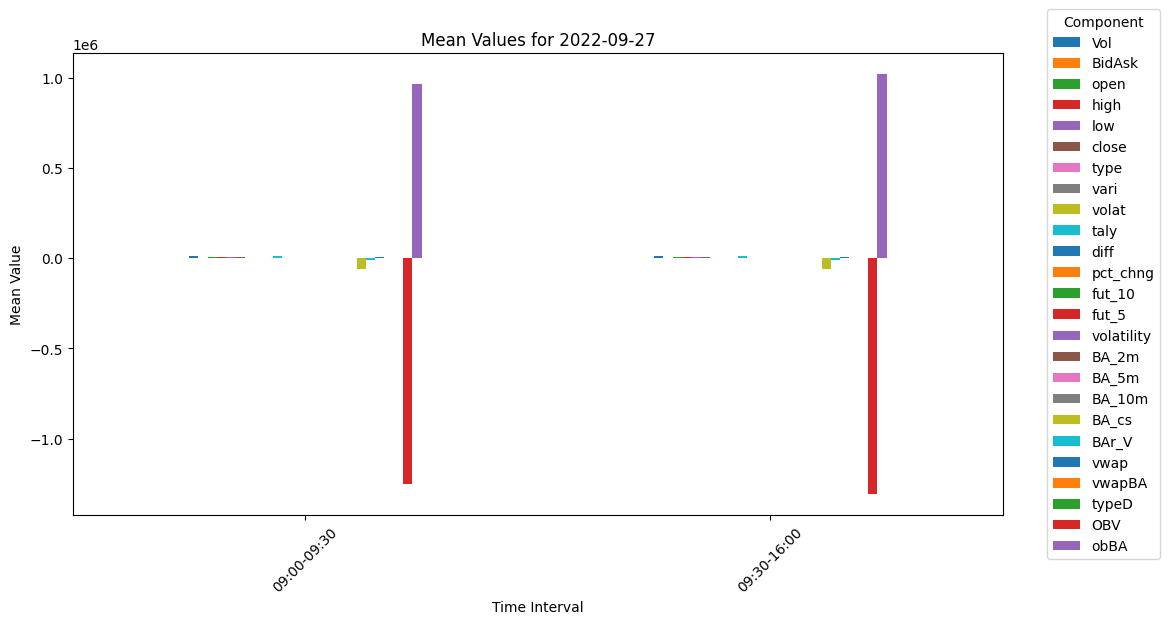

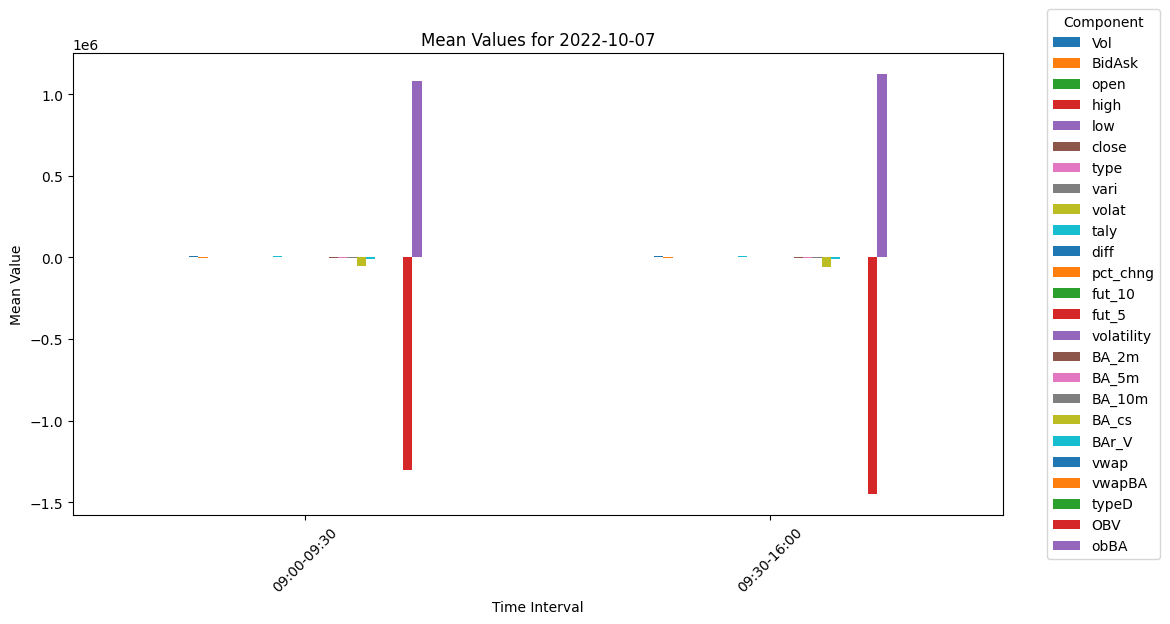

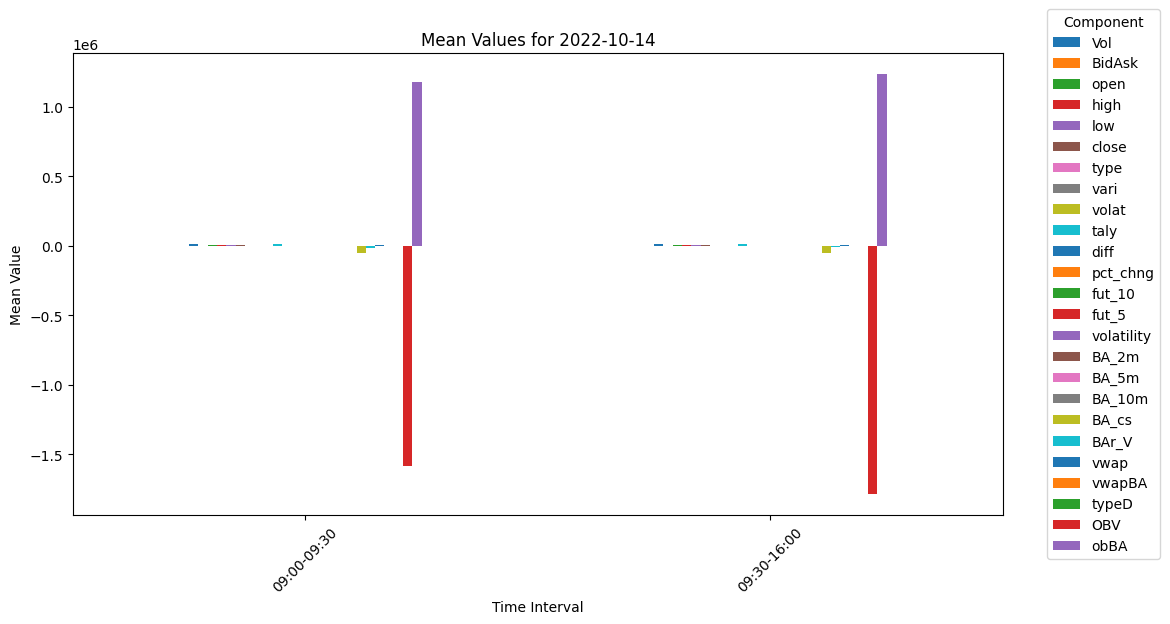

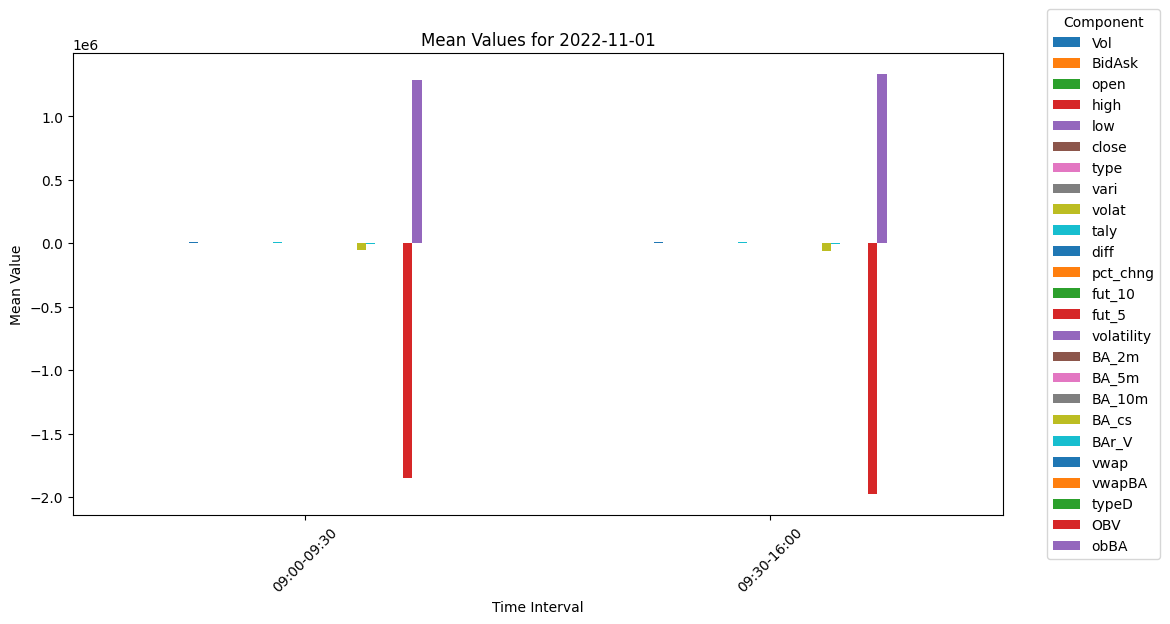

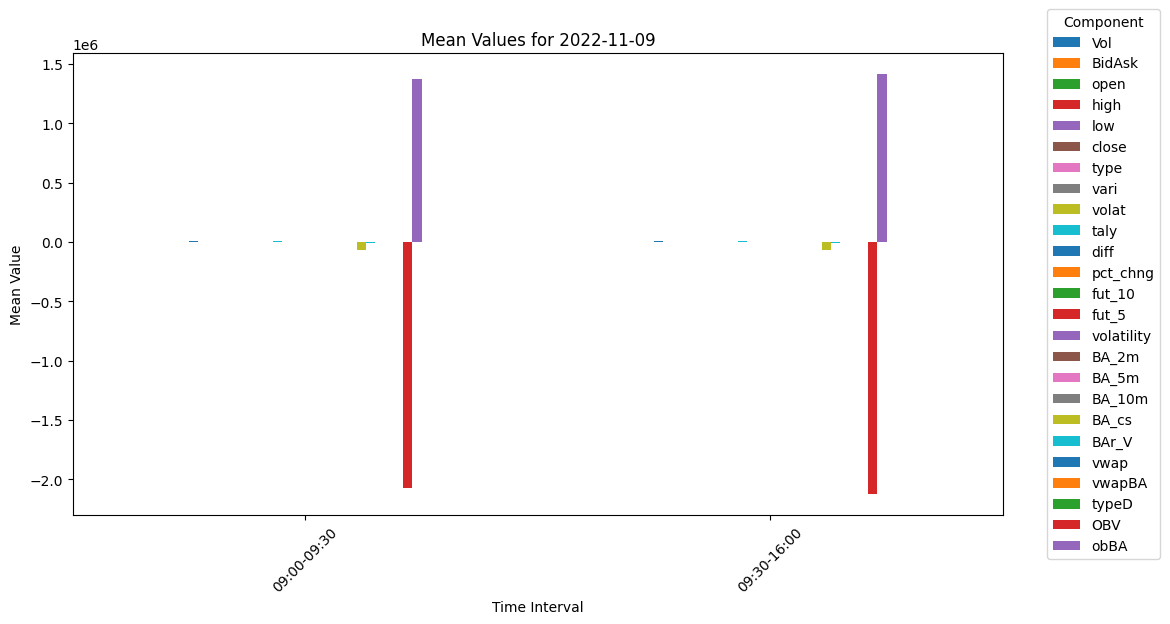

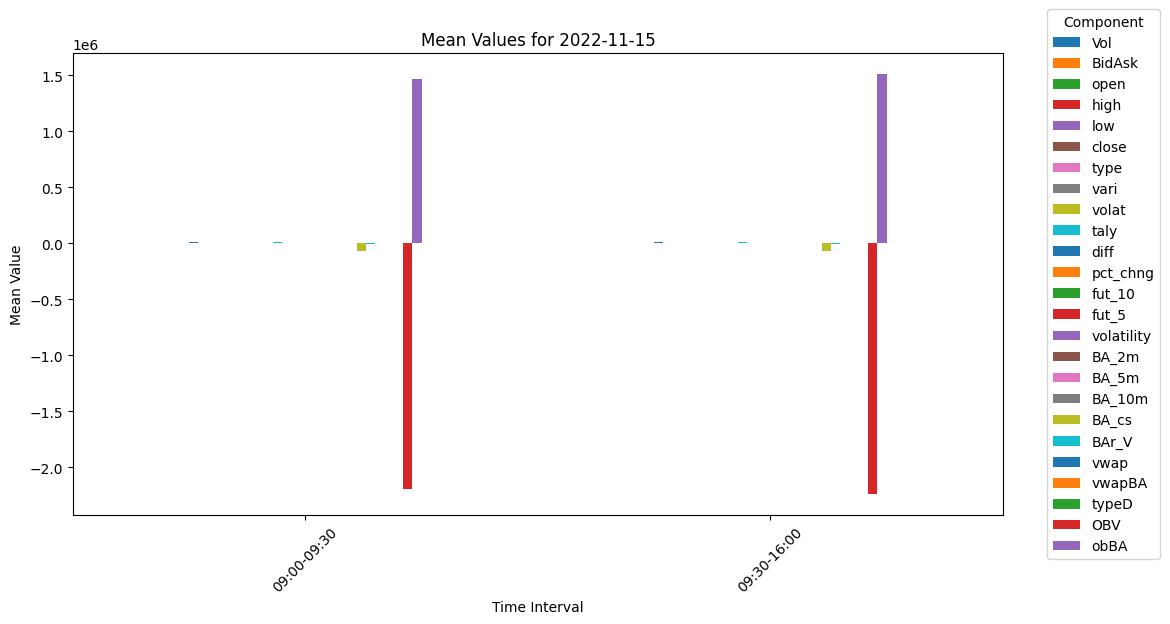

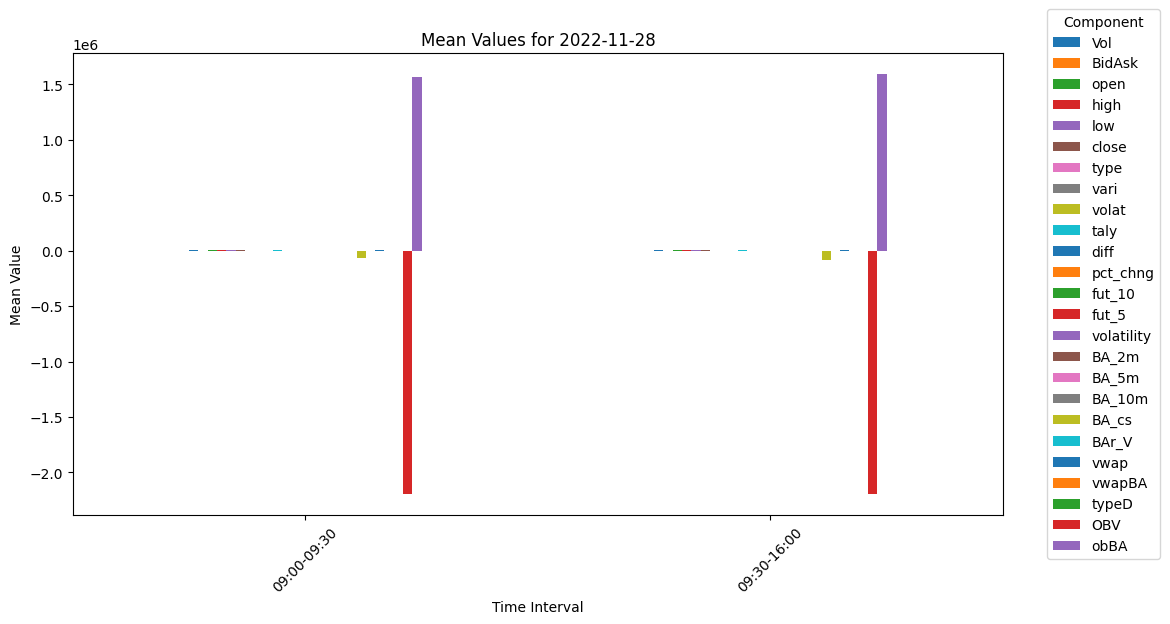

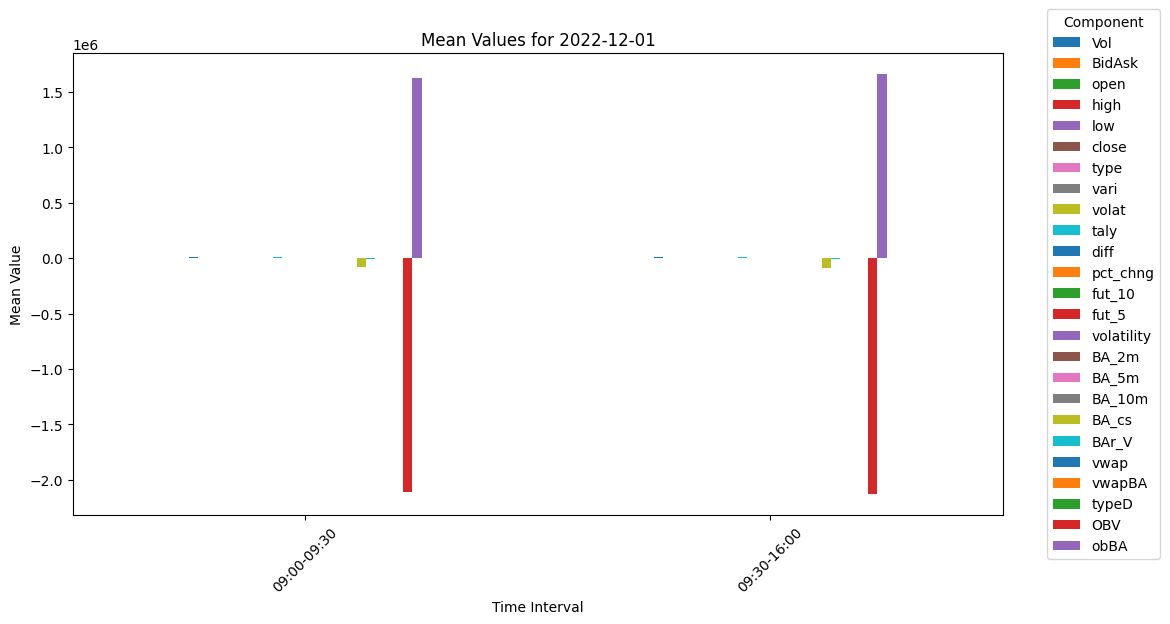

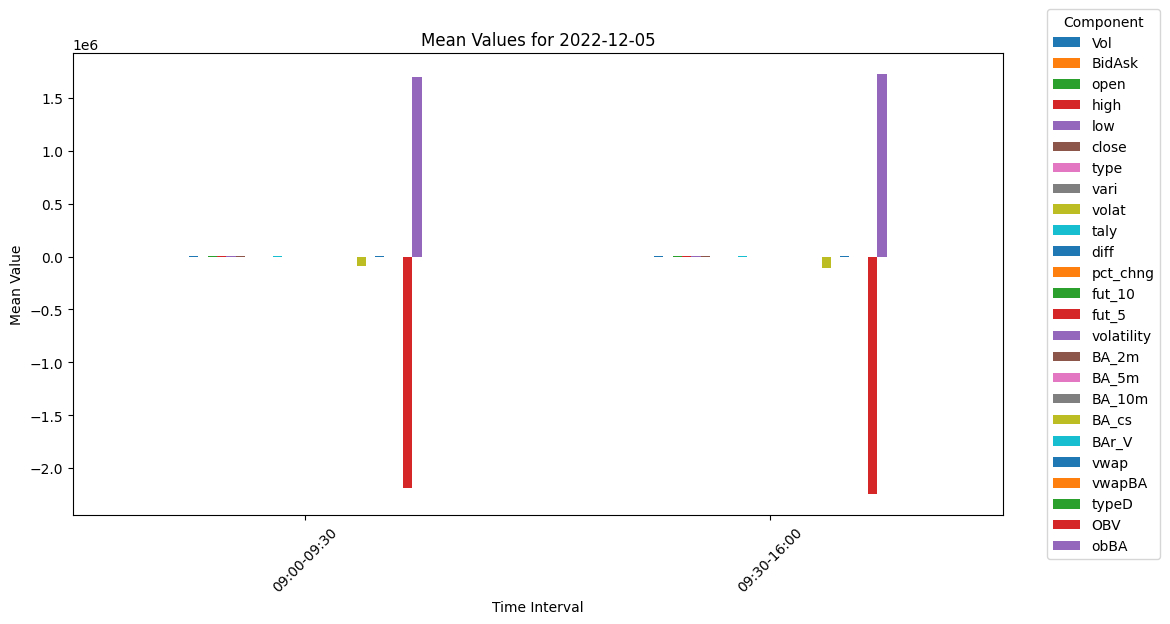

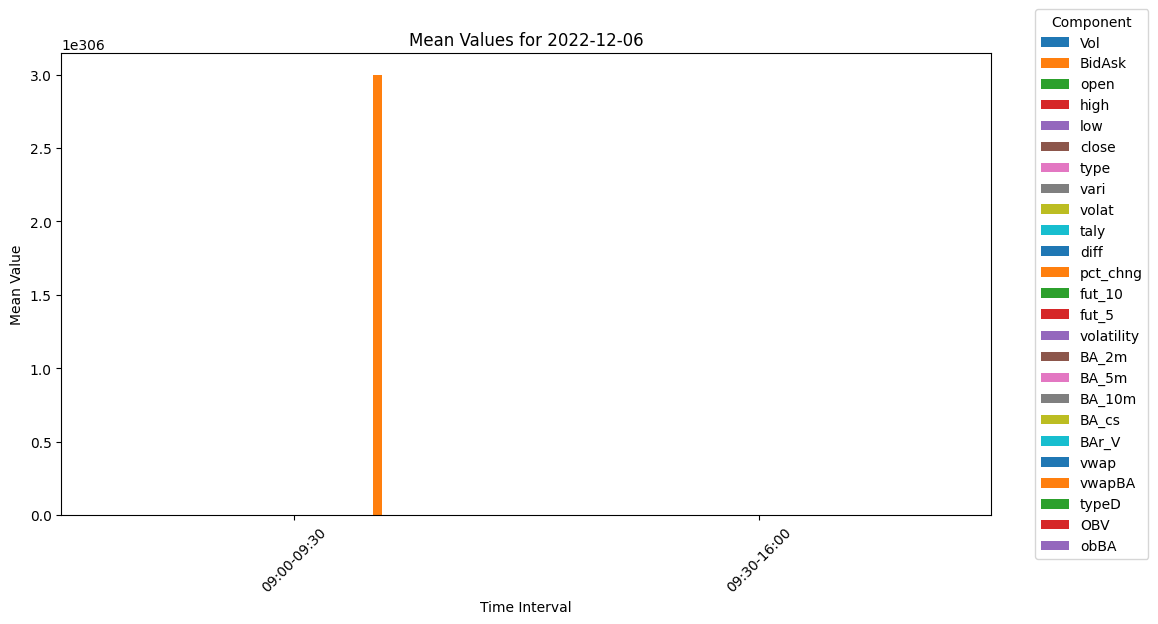

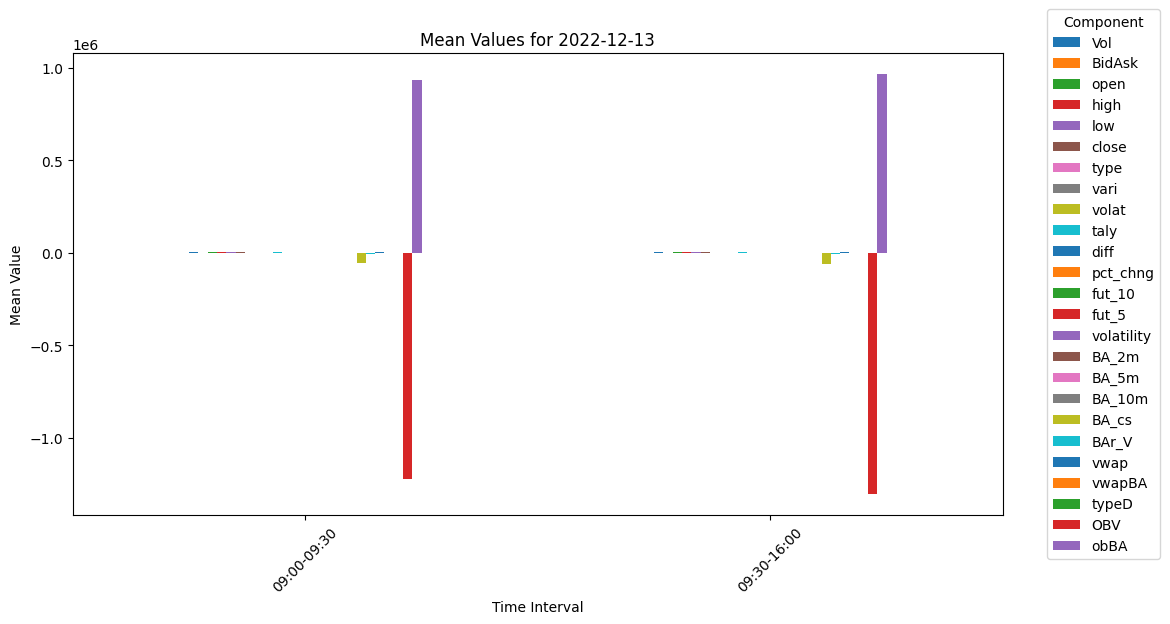

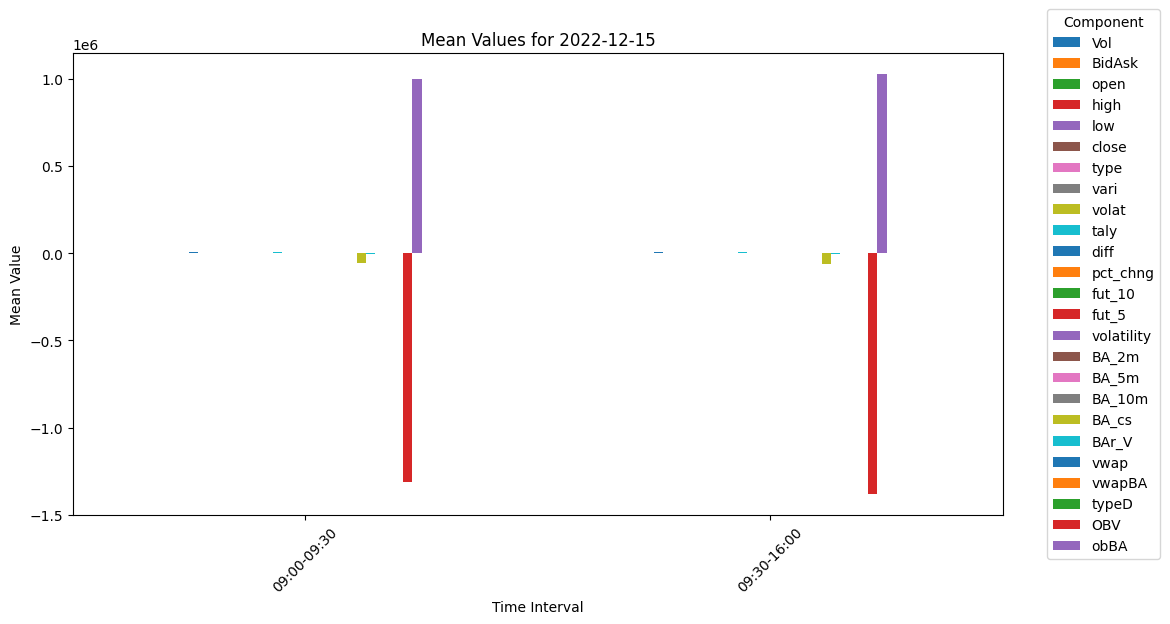

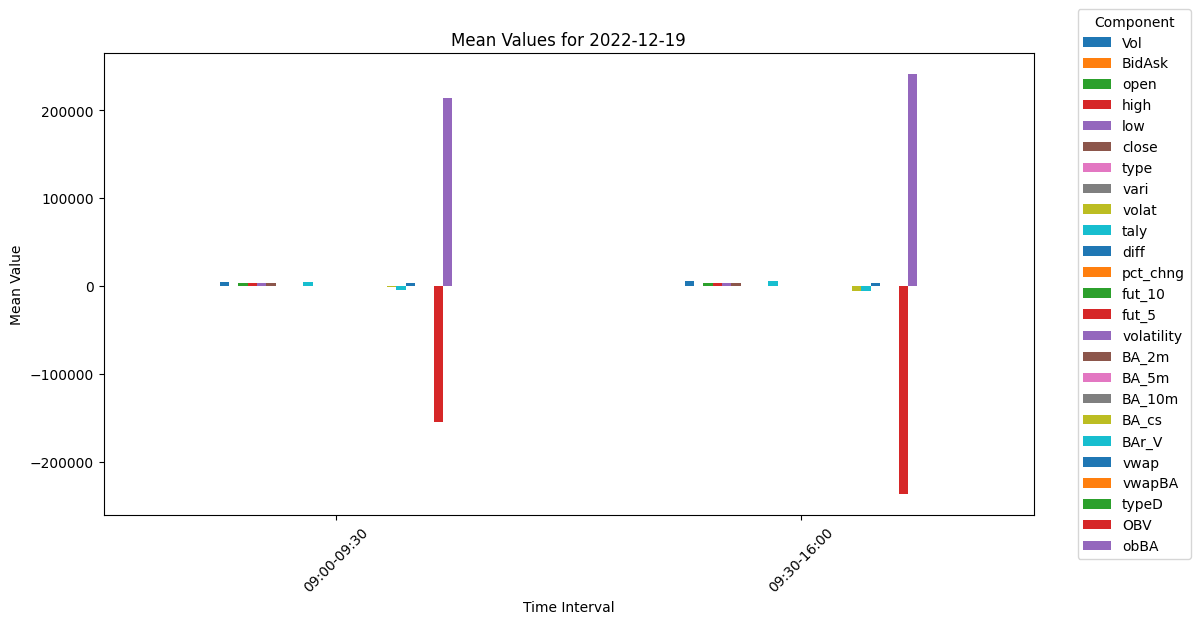

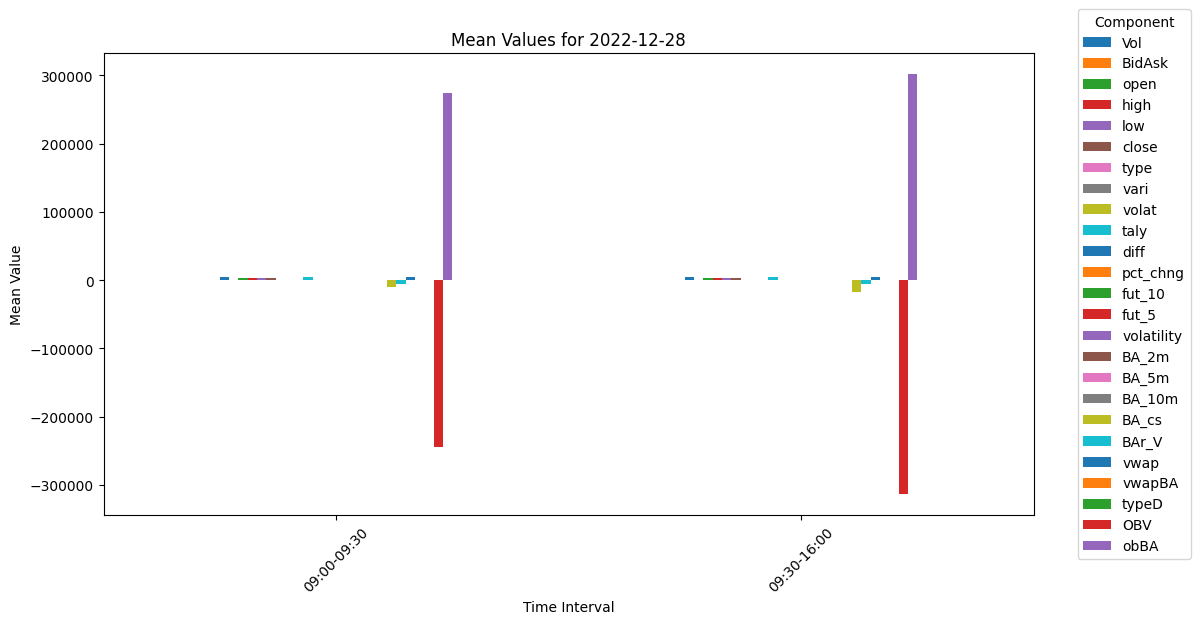

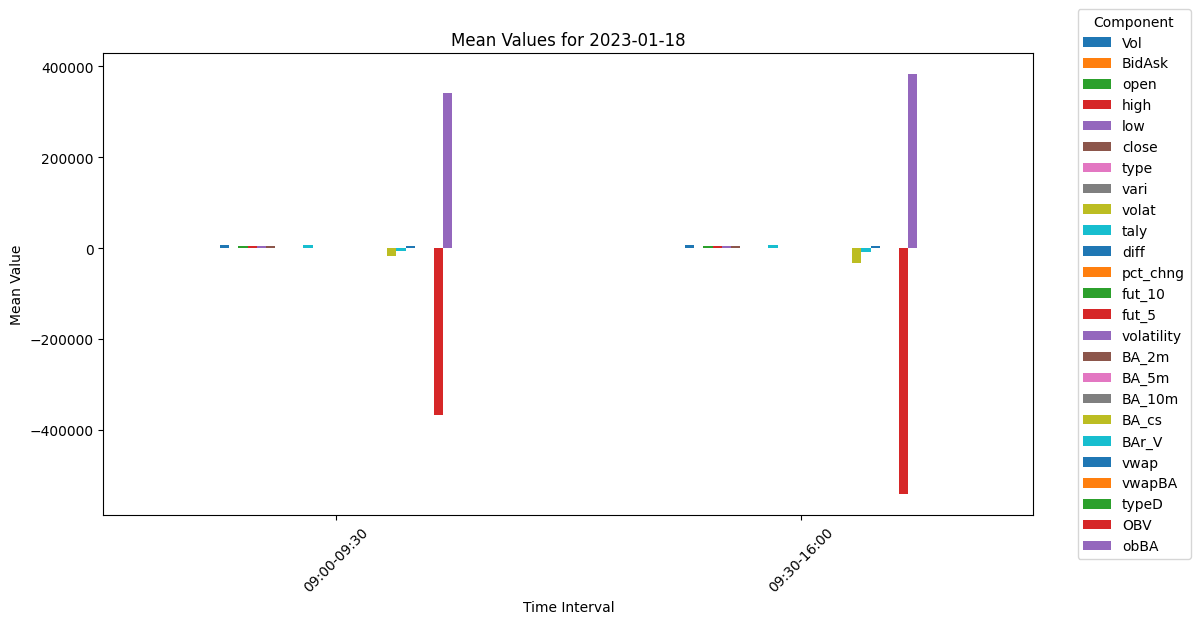

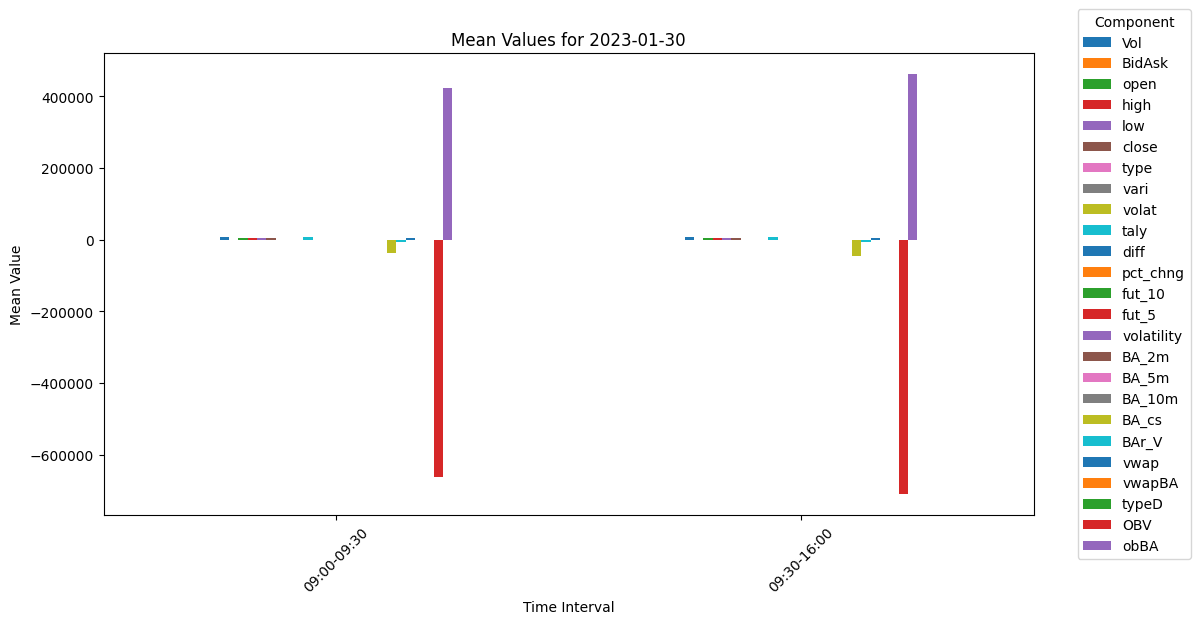

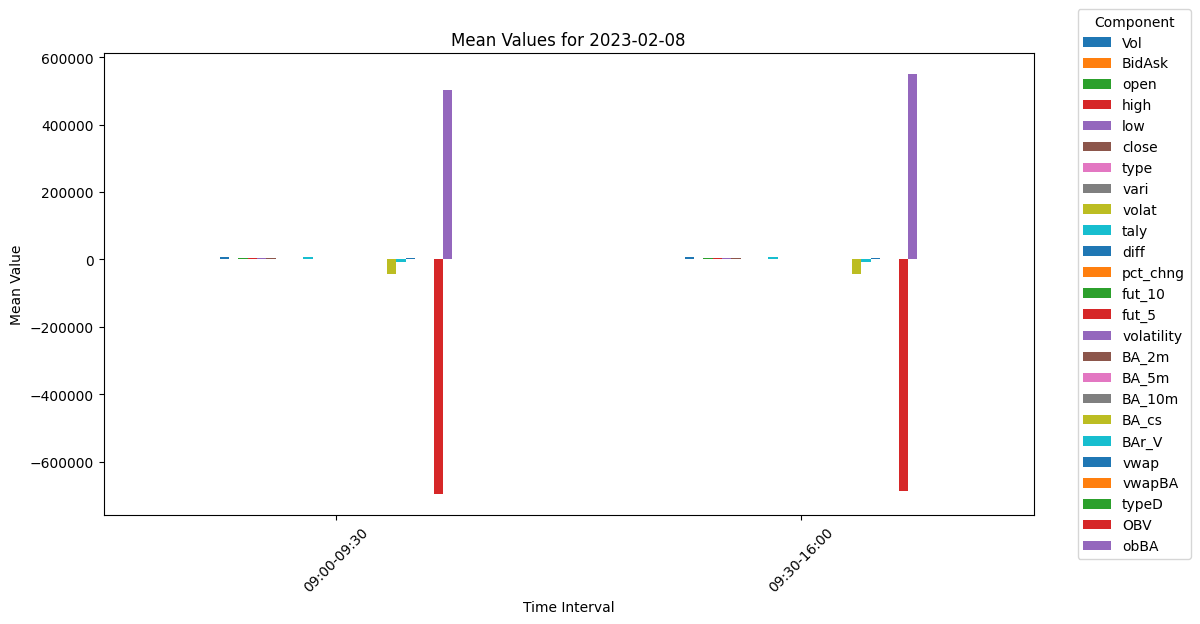

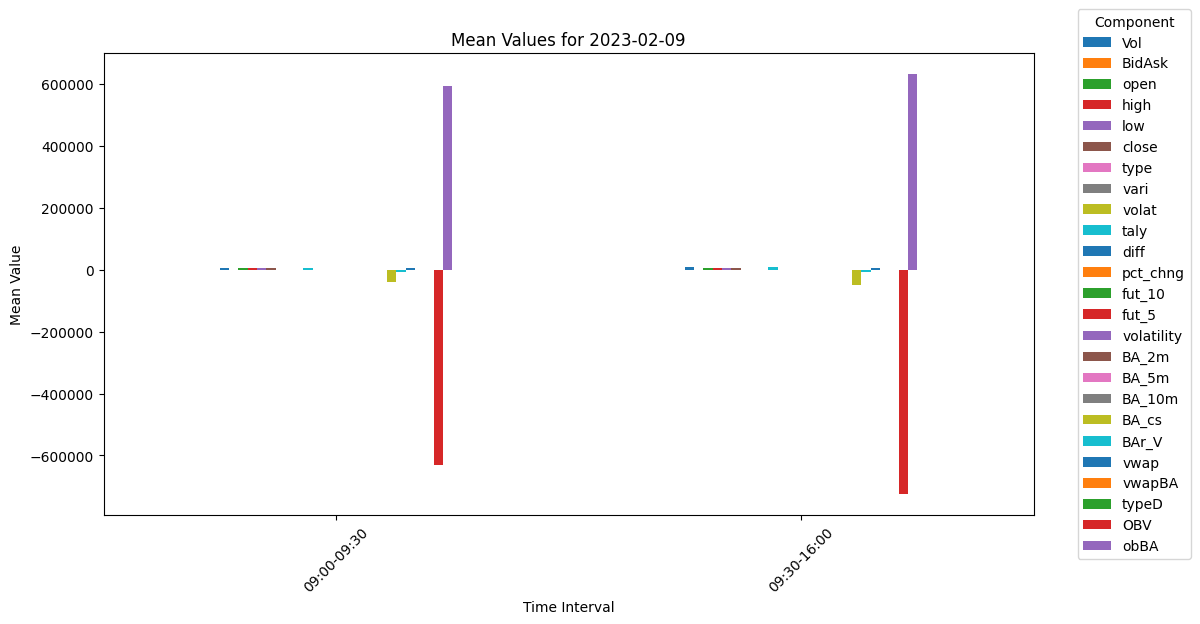

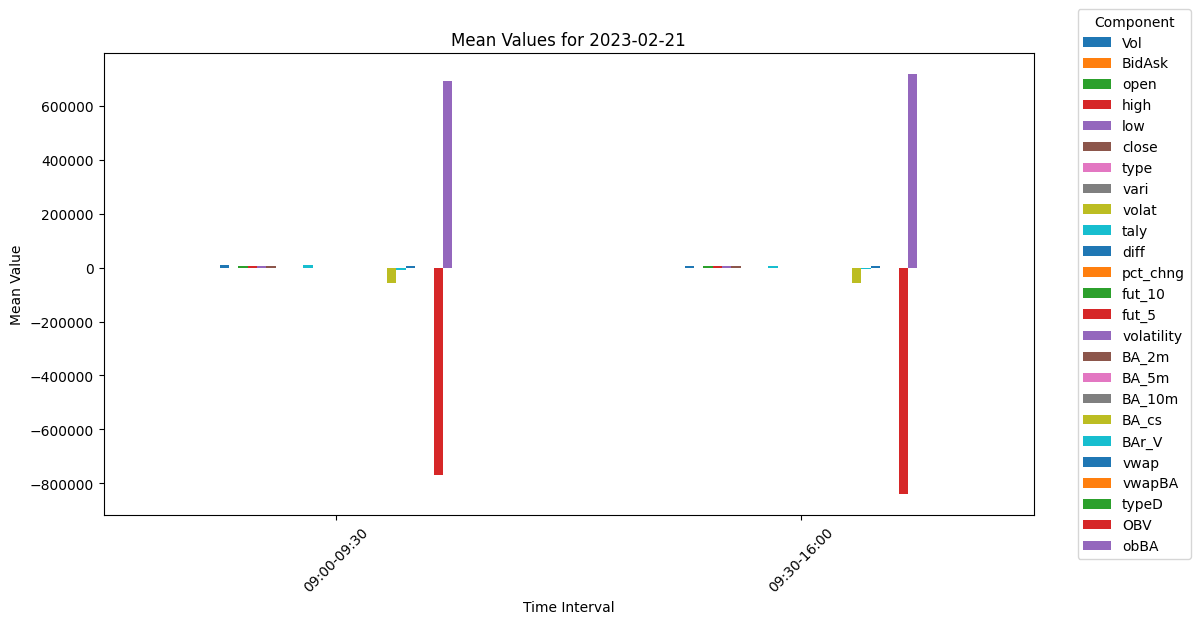

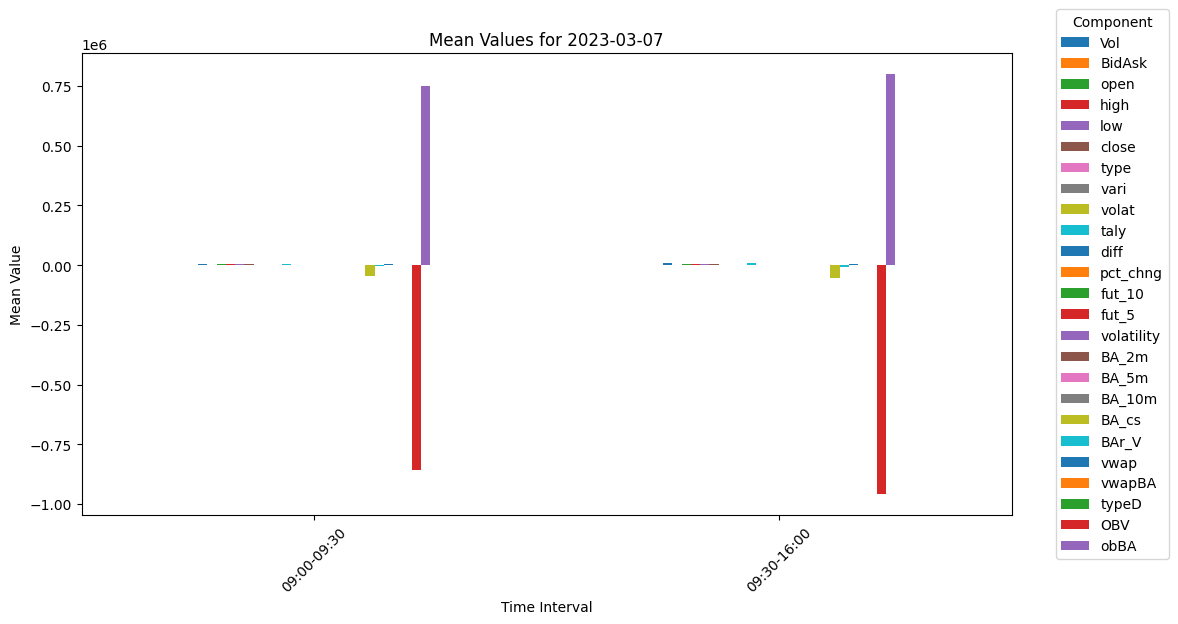

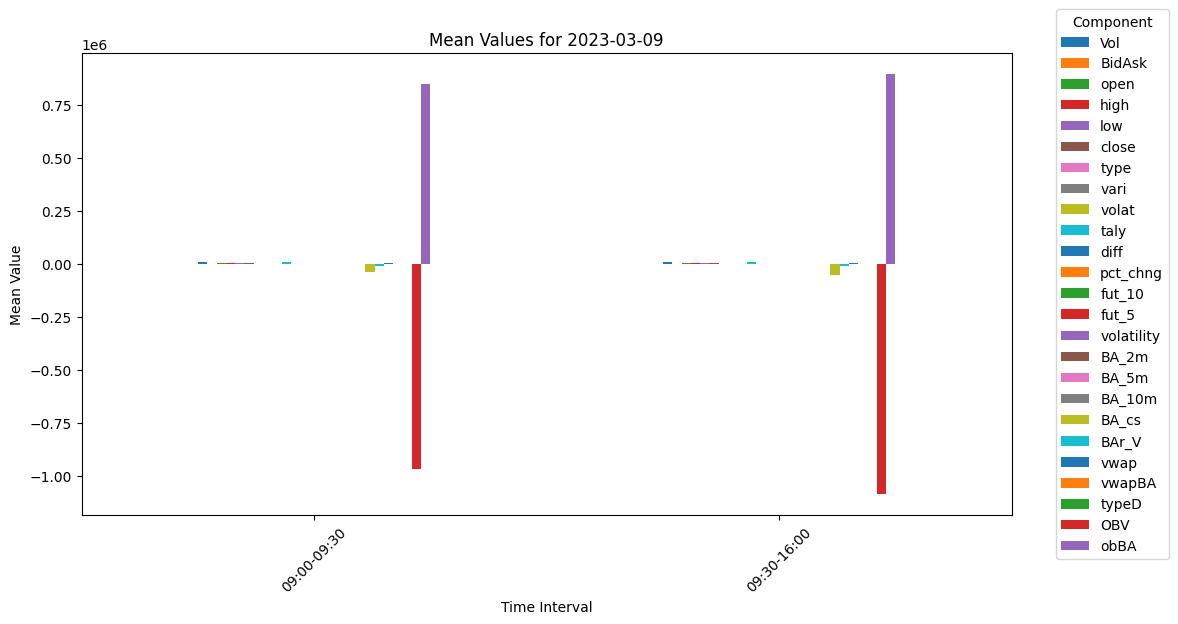

In [525]:
# import matplotlib.pyplot as plt

# nq_centered

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = esDown.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)

# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 9:30 am, and 9:30 am and 4 pm
    interval_9_to_930 = group.between_time('09:00', '09:30').dropna()
    rest_of_day = group.between_time('09:30', '16:00').dropna()

    # Check if both intervals have data
    if interval_9_to_930.empty or rest_of_day.empty:
        # print(f"Skipping {day} due to insufficient data")
        continue

    # Calculate the means for both parts
    mean_9_to_930 = interval_9_to_930.mean()
    mean_rest_of_day = rest_of_day.mean()

    # Combine the means into a new DataFrame
    combined_means = pd.concat([mean_9_to_930, mean_rest_of_day], axis=1).T
    combined_means.index = ['09:00-09:30', '09:30-16:00']

    # Plot the combined means as a bar plot
    combined_means.plot(kind='bar', figsize=(12, 6))
    plt.xlabel("Time Interval")
    plt.ylabel("Mean Value")
    plt.title(f"Mean Values for {day}")
    plt.legend(combined_means.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.xticks(range(len(combined_means.index)), combined_means.index, rotation=45)
    plt.show()


Singular values for the 9-10 hour: [           inf 1.97543714e+01 1.01800512e+01 8.42365404e+00
 5.91979787e+00 5.60479651e+00 4.75369137e+00 4.50906016e+00
 3.18591528e+00 2.78465076e+00 2.68477201e+00 2.13707592e+00
 2.11379700e+00 1.98898476e+00 1.94538986e+00 1.41818127e+00
 4.78111557e-01 2.84133226e-01 2.48002535e-01 1.90923710e-01
 1.18145156e-01 1.24470206e-02 3.93967617e-20]
Singular values for the 10-11 hour: [           inf 1.55543988e+01 1.09454351e+01 8.42782840e+00
 6.03885596e+00 5.48509613e+00 4.28477252e+00 4.06683578e+00
 3.51876556e+00 2.82130428e+00 2.69345640e+00 2.40078252e+00
 1.94379379e+00 1.88445102e+00 1.69394466e+00 1.48505235e+00
 3.62331533e-01 3.15381412e-01 2.91375372e-01 2.59330067e-01
 1.48789262e-01 1.49596490e-02 6.65266907e-19]


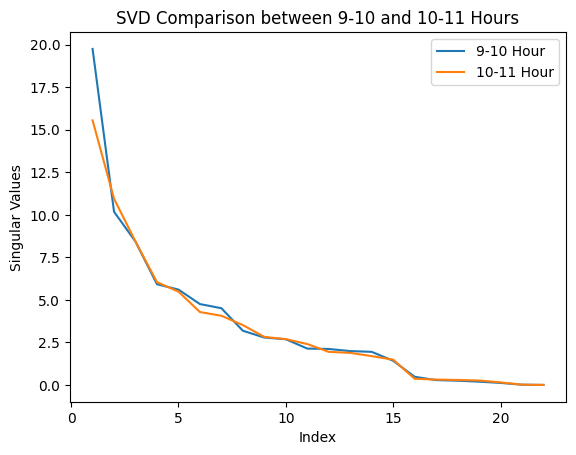

In [39]:
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has columns 'Date' and 'Close'
# Make sure the 'Date' column is set as the index and is a datetime object
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_10_to_11 = es_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
plt.plot(s_9_to_10, label="9-10 Hour")
plt.plot(s_10_to_11, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.legend()
plt.show()


Singular values for the 9-10 hour: [           inf 1.97543714e+01 1.01800512e+01 8.42365404e+00
 5.91979787e+00 5.60479651e+00 4.75369137e+00 4.50906016e+00
 3.18591528e+00 2.78465076e+00 2.68477201e+00 2.13707592e+00
 2.11379700e+00 1.98898476e+00 1.94538986e+00 1.41818127e+00
 4.78111557e-01 2.84133226e-01 2.48002535e-01 1.90923710e-01
 1.18145156e-01 1.24470206e-02 3.93967617e-20]
Singular values for the 10-11 hour: [            inf 3.39772070e+292 2.31392722e+001 1.23724510e+001
 8.62207450e+000 6.70880134e+000 5.64097804e+000 4.17874796e+000
 3.69818879e+000 3.52010499e+000 3.13342002e+000 2.98631275e+000
 2.68487943e+000 2.09633428e+000 1.84806742e+000 1.41517103e+000
 1.29113486e+000 2.73391118e-001 2.31483479e-001 1.59011600e-001
 1.39309947e-001 1.09527847e-002 6.30426040e-020]


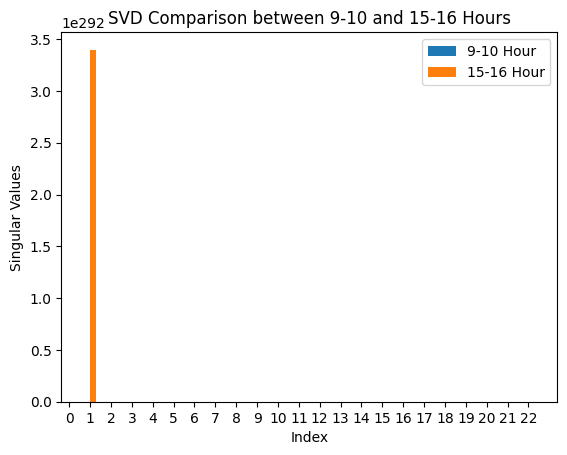

In [44]:


from scipy.linalg import svd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has columns 'Date' and 'Close'
# Make sure the 'Date' column is set as the index and is a datetime object
# df['DateTime'] = pd.to_datetime(df['DateTime'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_15_to_16 = es_centered.between_time('15:00', '16:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_15_to_16, s_15_to_16, Vh_15_to_16 = svd(df_15_to_16)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_15_to_16)

# Plot the SVD values using matplotlib
bar_width = 0.3
index = np.arange(len(s_9_to_10))

plt.bar(index, s_9_to_10, width=bar_width, label="9-10 Hour")
plt.bar(index + bar_width, s_15_to_16, width=bar_width, label="15-16 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 15-16 Hours")
plt.xticks(index + bar_width/2, index)
plt.legend()
plt.show()



Singular values for the 9-10 hour: [           inf 1.97543714e+01 1.01800512e+01 8.42365404e+00
 5.91979787e+00 5.60479651e+00 4.75369137e+00 4.50906016e+00
 3.18591528e+00 2.78465076e+00 2.68477201e+00 2.13707592e+00
 2.11379700e+00 1.98898476e+00 1.94538986e+00 1.41818127e+00
 4.78111557e-01 2.84133226e-01 2.48002535e-01 1.90923710e-01
 1.18145156e-01 1.24470206e-02 3.93967617e-20]
Singular values for the 10-11 hour: [           inf 1.55543988e+01 1.09454351e+01 8.42782840e+00
 6.03885596e+00 5.48509613e+00 4.28477252e+00 4.06683578e+00
 3.51876556e+00 2.82130428e+00 2.69345640e+00 2.40078252e+00
 1.94379379e+00 1.88445102e+00 1.69394466e+00 1.48505235e+00
 3.62331533e-01 3.15381412e-01 2.91375372e-01 2.59330067e-01
 1.48789262e-01 1.49596490e-02 6.65266907e-19]


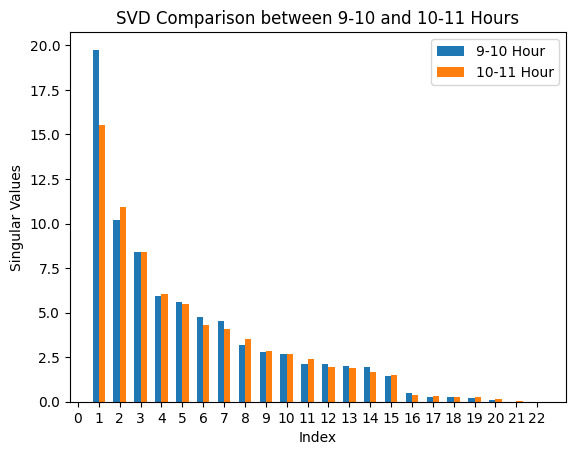

In [41]:

from scipy.linalg import svd
# import matplotlib.pyplot as plt

# df['DateTime'] = pd.to_datetime(df['DateTime'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = es_centered.between_time('9:00', '10:00')
df_10_to_11 = es_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
bar_width = 0.3
index = np.arange(len(s_9_to_10))

plt.bar(index, s_9_to_10, width=bar_width, label="9-10 Hour")
plt.bar(index + bar_width, s_10_to_11, width=bar_width, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.xticks(index + bar_width/2, index)
plt.legend()
plt.show()
